In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import scipy.stats
from pytorch_tabnet.tab_model import TabNetRegressor
from boruta import BorutaPy
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR

from sklearn.ensemble import IsolationForest
from lightgbm import LGBMRegressor

from utils import fill_col_nan_values
from sklearn.metrics import r2_score 

In [2]:
df = pd.read_csv('./original_data/X_train.csv')

In [3]:
df

id         x0             x1            x2           x3  \
0        0.0  10.891876  832442.812375  20585.544083  1028.369495   
1        1.0  11.512994  832442.898114           NaN  1012.624877   
2        2.0  11.052185  832442.896307  20585.512844  1003.953827   
3        3.0  11.642076            NaN           NaN  1004.672084   
4        4.0  10.407121  832442.831424  20585.557007          NaN   
...      ...        ...            ...           ...          ...   
1207  1207.0   9.895208  832442.883343  20585.510774  1082.657477   
1208  1208.0   9.838322  832442.816133  20585.530631  1020.816077   
1209  1209.0   9.267322  832442.815687  20585.525811  1076.663108   
1210  1210.0        NaN  832442.826707  20585.564056  1076.359217   
1211  1211.0   9.070810  832442.841694  20585.531908  1077.977276   

                x4         x5             x6            x7            x8  ...  \
0     1.163780e+06   9.199135  597900.477629           NaN  1.144294e+06  ...   
1     1.028911e+06  10.906408  597900.458612   8127.016078  1.099166e+06  ...   
2     9.231756e+05   9.212979  597900.426764  10738.092422  1.027863e+06  ...   
3     9.459461e+05   9.553420  597900.450367  13524.096973  1.168144e+06  ...   
4     9.957182e+05   8.419164  597900.423639  12894.065081  1.063199e+06  ...   
...            ...        ...            ...           ...           ...  ...   
1207  1.107019e+06  10.915545  597900.459438           NaN  1.020097e+06  ...   
1208  9.834291e+05        NaN  597900.428561  10842.043309  1.110318e+06  ...   
1209  7.651645e+05   9.579855            NaN           NaN  1.092330e+06  ...   
1210  9.332198e+05   8.863739  597900.402740  13121.042555  8.245987e+05  ...   
1211  9.568525e+05  10.894921  597900.446646   9947.064942  1.010069e+06  ...   

              x822         x823          x824       x825       x826  \
0     1.024198e+06  -855.549602  12176.073427  10.647729  10.916371   
1     1.086806e+06  -787.397942  10493.095660  10.586492   9.463962   
2     1.018533e+06  -906.997242  10959.516944  10.769287  10.342160   
3     1.047017e+06 -1011.742516  16845.309819  10.483830  10.594941   
4     1.031009e+06 -1025.223865  18348.460040        NaN        NaN   
...            ...          ...           ...        ...        ...   
1207  1.004860e+06  -999.439794  17689.388714  10.472291   9.792557   
1208  1.080810e+06 -1113.072752  15994.070051  10.269221   9.771282   
1209  1.047013e+06  -482.079954  11539.602821  10.346105  10.361797   
1210  1.070566e+06 -1063.653564  15108.683504  10.831122  10.167780   
1211  1.063663e+06  -857.771913  14506.181447  10.312122   8.608383   

             x827       x828          x829           x830           x831  
0     1220.065443   8.566724  1.036263e+06   85338.558539  103088.664210  
1      917.094909  10.231822  1.007163e+06   95695.020645  105161.109422  
2      637.027802  10.705461  1.019955e+06   80253.299882  104177.051666  
3     1114.069590  10.321063  1.085442e+06            NaN  102746.516920  
4     1230.088215  10.250096  1.024812e+06  101815.745499  105163.749149  
...           ...        ...           ...            ...            ...  
1207  1249.098796  10.939983  1.092890e+06   97402.723818  107110.572397  
1208  1402.080672  10.958833  1.083262e+06  107100.133295  109984.169649  
1209   965.008332  10.483549  1.007871e+06  119139.273272  105240.374580  
1210          NaN  10.647956  1.047863e+06  104741.008263  100272.537058  
1211  1237.051235        NaN  1.029894e+06            NaN  104448.183527  

[1212 rows x 833 columns]

In [4]:
y_df = pd.read_csv('./original_data/y_train.csv')
test_df = pd.read_csv('./original_data/X_test.csv')

In [5]:
y_df

id     y
0        0.0  71.0
1        1.0  73.0
2        2.0  66.0
3        3.0  55.0
4        4.0  67.0
...      ...   ...
1207  1207.0  67.0
1208  1208.0  48.0
1209  1209.0  82.0
1210  1210.0  76.0
1211  1211.0  81.0

[1212 rows x 2 columns]

<AxesSubplot:ylabel='Frequency'>

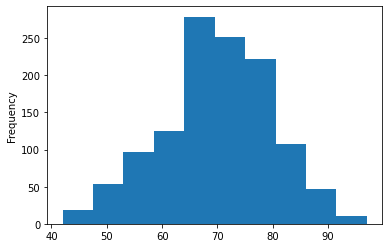

In [6]:
y_df['y'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

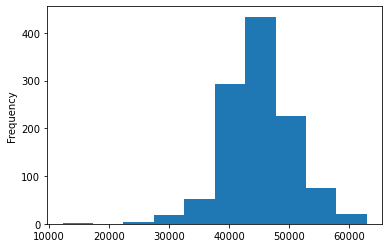

In [7]:
df['x10'].plot.hist()

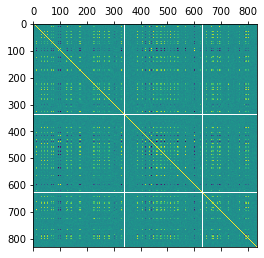

In [8]:
plt.matshow(df.corr())
plt.show()

# First Approach

Steps: median filling -> random forest regression for missing values -> outlier detection: isolation forest: 4 candidates, z-score: 0.9999 of 2+ dimensions - 97 age person -> feature selection: 2 options: w/o gaussian normalization + boruta algorithm (64 - 71 features selected 1é tentative) -> models: standard: lgbmregressor(0.66), randomforest regressor(0.65), tabnet(0.52, 0.6)

Filling missing values

In [7]:
df_median_filled = df.fillna(df.median())

In [5]:
def fill_col_nan_values(df, col, df_with_NaN):
    X = df[list(np.append(df.columns[1:][:col], df.columns[1:][col+1:]))]
    y = df[[df.columns[col]]]
    X_infer_idx = df_with_NaN[df_with_NaN[df_with_NaN.columns[col]].isna()].index
    train_X = X[~X.index.isin(X_infer_idx)]
    train_y = y[~y.index.isin(X_infer_idx)]
    predictor = RandomForestRegressor(max_depth=2, random_state=0).fit(train_X.values, train_y.values)
    new_col = list(df_with_NaN[[df.columns[col]]][df.columns[col]].values)
    for idx in X_infer_idx:
    new_col[idx] = predictor.predict(np.expand_dims(X.values[idx], axis=0))[0]
    return new_col

In [7]:
test_df = pd.read_csv('./origianl_data/X_test.csv')

In [13]:
df_regression_filled = df.copy()
for i in tqdm(range(2, len(df.columns))):
    df_regression_filled[df.columns[i]] = fill_col_nan_values(df_median_filled, i, df)

  0%|          | 0/832 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
  0%|          | 1/832 [00:11<2:37:47, 11.39s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
  0%|          | 2/832 [00:20<2:18:53, 10.04s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
  0%|          | 3/832 [00:31<2:27:14, 10.66s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed wh

In [10]:
df_regression_filled = test_df.copy()
test_df_median_filled = test_df.fillna(test_df.median())
for i in tqdm(range(1, len(test_df.columns))):
    df_regression_filled[test_df.columns[i]] = fill_col_nan_values(test_df_median_filled, i, test_df)

  0%|          | 0/832 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
  0%|          | 1/832 [00:06<1:35:03,  6.86s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
  0%|          | 2/832 [00:11<1:19:13,  5.73s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
  0%|          | 3/832 [00:18<1:26:04,  6.23s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed wh

In [12]:
df_regression_filled.to_csv('X_test_regression_filled.csv')

In [15]:
df = pd.read_csv('X_train_regression_filled.csv')

In [21]:
ydf = pd.read_csv('./origianl_data/y_train.csv')

In [87]:
scipy.stats.norm.ppf(0.99999)

4.264890793923841

In [39]:
cols = df.columns

In [43]:
df.mean()[2]

10.000394538982805

In [88]:
indexes = [0]*len(df)
for idx in tqdm(range(2, len(df.columns))):
  for i in df[df[cols[idx]] > df.mean()[idx] + scipy.stats.norm.ppf(0.99999)*df.std()[idx]].index:
    indexes[i] += 1
  for i in df[df[cols[idx]] < df.mean()[idx] - scipy.stats.norm.ppf(0.99999)*df.std()[idx]].index:
    indexes[i] += 1

100%|██████████| 832/832 [04:29<00:00,  3.09it/s]


In [99]:
outliers = [3, 652, 670, 1008]
for i, j in enumerate(indexes):
  if j > 2:
    print(i, j)
    outliers.append(i)

97 4
205 10
279 7
313 28
361 4
415 4
426 58
431 3
487 3
605 7
685 5
732 7
746 3
848 5
981 9
997 3
1060 3
1102 5
1116 3


In [106]:
ydf['y'].max()

97.0

In [111]:
outliers.remove(487)

In [112]:
for i in outliers:
  print(i, ydf['y'][i])

3 55.0
652 87.0
670 50.0
1008 86.0
97 84.0
205 51.0
279 75.0
313 70.0
361 78.0
415 81.0
426 46.0
431 62.0
605 79.0
685 77.0
732 48.0
746 81.0
848 78.0
981 49.0
997 82.0
1060 58.0
1102 79.0
1116 76.0


In [116]:
df[~df.index.isin(outliers)].reset_index()[df.columns[2:]].to_csv('X_train_no_outliers.csv')

In [ ]:
pip install Boruta

In [185]:
Xdf = df[~df.index.isin(outliers)].reset_index()[df.columns[2:]]
Ydf = ydf[~ydf.index.isin(outliers)].reset_index()[ydf.columns[1:]]

In [191]:
rf = RandomForestRegressor(n_jobs=-1,  max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
normalized_Xdf=(Xdf-Xdf.mean())/(Xdf.std() + 1e-15)
X_transformed = feat_selector.fit_transform(normalized_Xdf.values, Ydf.values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	832
Rejected: 	0


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	832
Rejected: 	0


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	832
Rejected: 	0


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	832
Rejected: 	0


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	832
Rejected: 	0


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	832
Rejected: 	0


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	832
Rejected: 	0


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	737


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	9 / 100
Confirmed: 	24
Tentative: 	71
Rejected: 	737


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	10 / 100
Confirmed: 	24
Tentative: 	71
Rejected: 	737


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	11 / 100
Confirmed: 	24
Tentative: 	71
Rejected: 	737


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	12 / 100
Confirmed: 	37
Tentative: 	51
Rejected: 	744


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	13 / 100
Confirmed: 	37
Tentative: 	51
Rejected: 	744


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	14 / 100
Confirmed: 	37
Tentative: 	51
Rejected: 	744


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	15 / 100
Confirmed: 	37
Tentative: 	51
Rejected: 	744


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	16 / 100
Confirmed: 	42
Tentative: 	46
Rejected: 	744


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	17 / 100
Confirmed: 	42
Tentative: 	46
Rejected: 	744


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	18 / 100
Confirmed: 	42
Tentative: 	44
Rejected: 	746


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	19 / 100
Confirmed: 	43
Tentative: 	43
Rejected: 	746


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	20 / 100
Confirmed: 	43
Tentative: 	40
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	21 / 100
Confirmed: 	43
Tentative: 	40
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	22 / 100
Confirmed: 	43
Tentative: 	40
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	23 / 100
Confirmed: 	43
Tentative: 	40
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	24 / 100
Confirmed: 	43
Tentative: 	40
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	25 / 100
Confirmed: 	43
Tentative: 	40
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	26 / 100
Confirmed: 	44
Tentative: 	39
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	27 / 100
Confirmed: 	44
Tentative: 	39
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	28 / 100
Confirmed: 	44
Tentative: 	39
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	29 / 100
Confirmed: 	46
Tentative: 	37
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	30 / 100
Confirmed: 	46
Tentative: 	37
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	31 / 100
Confirmed: 	46
Tentative: 	37
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	32 / 100
Confirmed: 	46
Tentative: 	37
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	33 / 100
Confirmed: 	46
Tentative: 	37
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	34 / 100
Confirmed: 	50
Tentative: 	33
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	35 / 100
Confirmed: 	50
Tentative: 	33
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	36 / 100
Confirmed: 	50
Tentative: 	33
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	37 / 100
Confirmed: 	54
Tentative: 	29
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	38 / 100
Confirmed: 	54
Tentative: 	29
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	39 / 100
Confirmed: 	54
Tentative: 	29
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	40 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	41 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	42 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	43 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	44 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	45 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	46 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	47 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	48 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	49 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	50 / 100
Confirmed: 	55
Tentative: 	28
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	51 / 100
Confirmed: 	58
Tentative: 	25
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	52 / 100
Confirmed: 	58
Tentative: 	25
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	53 / 100
Confirmed: 	58
Tentative: 	25
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	54 / 100
Confirmed: 	60
Tentative: 	23
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	55 / 100
Confirmed: 	60
Tentative: 	23
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	56 / 100
Confirmed: 	60
Tentative: 	23
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	57 / 100
Confirmed: 	60
Tentative: 	23
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	58 / 100
Confirmed: 	60
Tentative: 	23
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	59 / 100
Confirmed: 	60
Tentative: 	23
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	60 / 100
Confirmed: 	60
Tentative: 	23
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	61 / 100
Confirmed: 	60
Tentative: 	23
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	62 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	63 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	64 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	65 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	66 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	67 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	68 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	69 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	70 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	71 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	72 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	73 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	74 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	75 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	76 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	77 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	78 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	79 / 100
Confirmed: 	61
Tentative: 	22
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	80 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	81 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	82 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	83 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	84 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	85 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	86 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	87 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	88 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	89 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	90 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	91 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	92 / 100
Confirmed: 	62
Tentative: 	21
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	93 / 100
Confirmed: 	63
Tentative: 	20
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	94 / 100
Confirmed: 	63
Tentative: 	20
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	95 / 100
Confirmed: 	63
Tentative: 	20
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	96 / 100
Confirmed: 	63
Tentative: 	20
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	97 / 100
Confirmed: 	63
Tentative: 	20
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	98 / 100
Confirmed: 	63
Tentative: 	20
Rejected: 	749


/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	99 / 100
Confirmed: 	63
Tentative: 	20
Rejected: 	749


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	63
Tentative: 	19
Rejected: 	749


In [134]:
Xdf

x0             x1  ...           x830           x831
0     10.891876  832442.812375  ...   85338.558539  103088.664210
1     11.512994  832442.898114  ...   95695.020645  105161.109422
2     11.052185  832442.896307  ...   80253.299882  104177.051666
3     10.407121  832442.831424  ...  101815.745499  105163.749149
4      9.144461  832442.882921  ...   90435.964659  109082.145240
...         ...            ...  ...            ...            ...
1185   9.895208  832442.883343  ...   97402.723818  107110.572397
1186   9.838322  832442.816133  ...  107100.133295  109984.169649
1187   9.267322  832442.815687  ...  119139.273272  105240.374580
1188   9.695172  832442.826707  ...  104741.008263  100272.537058
1189   9.070810  832442.841694  ...  101100.125448  104448.183527

[1190 rows x 832 columns]

In [192]:
selected_features = []
for i, j in enumerate(feat_selector.support_):
    if j:
        selected_features.append(i)

In [ ]:
selected_features

In [194]:
X_train_cleaned = df[~df.index.isin(outliers)].reset_index()[df.columns[1:]][['id'] + ['x' + str(x) for x in selected_features]]

In [195]:
X_train_cleaned 

id            x7           x12  ...      x786      x800      x819
0        0.0   9714.486157  67475.900839  ...  2.328664  2.358928  2.139276
1        1.0   8127.016078  93179.779900  ...  1.847425  1.886463  1.746126
2        2.0  10738.092422  69377.195188  ...  2.171014  2.406808  2.421048
3        4.0  12894.065081  90224.274392  ...  2.226530  2.404909  2.252717
4        5.0   9730.044411  84175.428187  ...  2.226163  2.385150  2.271308
...      ...           ...           ...  ...       ...       ...       ...
1185  1207.0   9714.486157  93014.492377  ...  2.303749  2.435243  2.513763
1186  1208.0  10842.043309  83111.101504  ...  2.309378  2.583037  2.434601
1187  1209.0   9714.486157  72269.035699  ...  2.136668  2.439831  1.982227
1188  1210.0  13121.042555  91240.616957  ...  2.234367  2.439831  2.276111
1189  1211.0   9947.064942  81405.108698  ...  2.325401  2.404375  2.183188

[1190 rows x 64 columns]

In [244]:
X_train_cleaned.to_csv('X_train_cleaned.csv')

In [303]:
X_train_cleaned_feat = pd.read_csv('Cleaned_data/X_train_cleaned.csv')
#X_train_cleaned = pd.read_csv('Cleaned_data/X_train_no_outliers.csv')
#X_train_cleaned = pd.read_csv('Cleaned_data/X_train_regression_filled.csv')
X_train_cleaned = pd.read_csv('original_data/X_train.csv')

In [304]:
X_train_cleaned_feat.columns[1:]

Index(['id', 'x7', 'x12', 'x30', 'x35', 'x52', 'x68', 'x85', 'x93', 'x101',
       'x170', 'x184', 'x192', 'x200', 'x207', 'x214', 'x227', 'x233', 'x246',
       'x275', 'x289', 'x302', 'x343', 'x360', 'x375', 'x387', 'x400', 'x403',
       'x408', 'x417', 'x447', 'x462', 'x473', 'x476', 'x482', 'x496', 'x523',
       'x536', 'x537', 'x540', 'x546', 'x559', 'x575', 'x579', 'x597', 'x599',
       'x619', 'x635', 'x662', 'x669', 'x672', 'x685', 'x717', 'x726', 'x738',
       'x749', 'x761', 'x772', 'x776', 'x783', 'x785', 'x786', 'x800', 'x819'],
      dtype='object')

In [305]:
X_train_cleaned = X_train_cleaned.fillna(X_train_cleaned.median())
X_train_cleaned = X_train_cleaned[X_train_cleaned_feat.columns[1:]]

In [299]:
X_train_cleaned

x7           x12       x30          x35       x52       x68  \
0     10295.013382  67475.900839  1.965179  5555.414472  2.075892  2.619178   
1      8127.016078  93179.779900  1.716548  4784.223551  2.244688  2.177003   
2     10738.092422  69377.195188  2.340156  4317.864410  2.393432  2.371338   
3     13524.096973  85953.175663  2.424319  5728.033993  2.558251  2.960585   
4     12894.065081  90224.274392  2.093927  5535.494157  2.358593  2.777702   
...            ...           ...       ...          ...       ...       ...   
1207  10295.013382  93014.492377  2.183230  4742.738037  2.432543  2.803976   
1208  10842.043309  83111.101504  2.312183  5719.673894  2.244688  2.842828   
1209  10295.013382  72269.035699  1.972920  3873.671597  1.963613  2.187795   
1210  13121.042555  91240.616957  2.209447  4463.091673  2.373418  2.652413   
1211   9947.064942  81405.108698  1.947990  4912.408872  2.244498  2.633804   

               x85          x93           x101         x170  ...         x738  \
0      2827.633110 -2779.425620 -346204.735158   688.451142  ...  5285.028834   
1     17622.701107 -2273.018366 -373656.073440  3848.155273  ...  6623.045843   
2      2275.991296 -2169.349108 -350829.277370   641.868780  ...  5846.010698   
3       991.045547 -4263.262355 -482798.666424   231.043720  ...  9374.075593   
4      1592.045883 -4834.430828 -444433.309297   398.678181  ...  6872.005840   
...            ...          ...            ...          ...  ...          ...   
1207   3389.686889 -4635.749026 -465331.544987   546.294025  ...  8139.082568   
1208   1266.683800 -3236.412945 -421414.072088    84.904704  ...  7527.019788   
1209  13048.290268 -3446.560428 -314818.038122   513.597725  ...  5915.057563   
1210   7314.661057 -3443.214080 -454299.373558  1085.534015  ...  7601.048717   
1211  12567.447884 -3707.979080 -399914.214294   558.589488  ...  7095.083182   

             x749           x761      x772         x776          x783  \
0      720.099067  213245.992433  1.999879   721.529170  16053.672538   
1      608.070629  281514.969554  1.895268  2610.588172  23841.492645   
2      647.014425  213245.992433  2.309962   595.101994  17141.615450   
3      976.092378  250295.858867  2.340377   608.024214  23914.059050   
4      857.037055  228479.204141  2.156590   154.266692  21434.911682   
...           ...            ...       ...          ...           ...   
1207  1017.046008  244427.732600  2.169546   316.858956  23019.905277   
1208   913.005593  233166.062691  2.205434   136.728218  20548.478259   
1209   529.030369  193783.783947  1.978914   472.758038  18024.192268   
1210   979.034507  245914.457718  2.178606  1265.911434  19360.265125   
1211   798.044249  218464.462352  2.025174   322.106153  19854.747928   

             x785      x786      x800      x819  
0     2457.075229  2.328664  2.358928  2.139276  
1     2295.387016  1.847425  1.886463  1.746126  
2     1471.906345  2.171014  2.406808  2.421048  
3      884.023158  2.622310  2.646011  2.618742  
4     1832.255623  2.226530  2.404909  2.252717  
...           ...       ...       ...       ...  
1207  1396.289655  2.303749  2.435243  2.513763  
1208   579.319182  2.309378  2.583037  2.434601  
1209  1439.130343  2.136668  2.377913  1.982227  
1210  3313.950751  2.244905  2.377913  2.276111  
1211  1120.288750  2.325401  2.404375  2.183188  

[1212 rows x 63 columns]

In [306]:
normalized_df=(X_train_cleaned-X_train_cleaned.mean())/X_train_cleaned.std()

In [249]:
from lightgbm import LGBMRegressor

In [257]:
from sklearn.ensemble import RandomForestRegressor

#clf = RandomForestRegressor(max_depth=20)
clf = LGBMRegressor(learning_rate = 0.1, n_estimators = 350, reg_alpha = 0.35)

In [301]:
outliers = [3, 652, 670, 1008, 97, 205, 279, 313, 361, 415, 426, 431, 605, 685, 732, 746, 848, 981, 997, 1060, 1102, 1116]

In [307]:
x = normalized_df[~X_train_cleaned.id.isin(outliers)][normalized_df.columns[1:]]
clf.fit(x.values,
        y_df[~y_df.id.isin(outliers)]['y'].values)

LGBMRegressor(n_estimators=350, reg_alpha=0.35)

In [308]:
#X_test = pd.read_csv('Cleaned_data/X_test_regression_filled.csv')
X_test = pd.read_csv('original_data/X_test.csv')
X_test = X_test.fillna(X_test.median())

In [309]:
X_train_cleaned

id            x7           x12       x30          x35       x52  \
0        0.0  10295.013382  67475.900839  1.965179  5555.414472  2.075892   
1        1.0   8127.016078  93179.779900  1.716548  4784.223551  2.244688   
2        2.0  10738.092422  69377.195188  2.340156  4317.864410  2.393432   
3        3.0  13524.096973  85953.175663  2.424319  5728.033993  2.558251   
4        4.0  12894.065081  90224.274392  2.093927  5535.494157  2.358593   
...      ...           ...           ...       ...          ...       ...   
1207  1207.0  10295.013382  93014.492377  2.183230  4742.738037  2.432543   
1208  1208.0  10842.043309  83111.101504  2.312183  5719.673894  2.244688   
1209  1209.0  10295.013382  72269.035699  1.972920  3873.671597  1.963613   
1210  1210.0  13121.042555  91240.616957  2.209447  4463.091673  2.373418   
1211  1211.0   9947.064942  81405.108698  1.947990  4912.408872  2.244498   

           x68           x85          x93           x101  ...         x738  \
0     2.619178   2827.633110 -2779.425620 -346204.735158  ...  5285.028834   
1     2.177003  17622.701107 -2273.018366 -373656.073440  ...  6623.045843   
2     2.371338   2275.991296 -2169.349108 -350829.277370  ...  5846.010698   
3     2.960585    991.045547 -4263.262355 -482798.666424  ...  9374.075593   
4     2.777702   1592.045883 -4834.430828 -444433.309297  ...  6872.005840   
...        ...           ...          ...            ...  ...          ...   
1207  2.803976   3389.686889 -4635.749026 -465331.544987  ...  8139.082568   
1208  2.842828   1266.683800 -3236.412945 -421414.072088  ...  7527.019788   
1209  2.187795  13048.290268 -3446.560428 -314818.038122  ...  5915.057563   
1210  2.652413   7314.661057 -3443.214080 -454299.373558  ...  7601.048717   
1211  2.633804  12567.447884 -3707.979080 -399914.214294  ...  7095.083182   

             x749           x761      x772         x776          x783  \
0      720.099067  213245.992433  1.999879   721.529170  16053.672538   
1      608.070629  281514.969554  1.895268  2610.588172  23841.492645   
2      647.014425  213245.992433  2.309962   595.101994  17141.615450   
3      976.092378  250295.858867  2.340377   608.024214  23914.059050   
4      857.037055  228479.204141  2.156590   154.266692  21434.911682   
...           ...            ...       ...          ...           ...   
1207  1017.046008  244427.732600  2.169546   316.858956  23019.905277   
1208   913.005593  233166.062691  2.205434   136.728218  20548.478259   
1209   529.030369  193783.783947  1.978914   472.758038  18024.192268   
1210   979.034507  245914.457718  2.178606  1265.911434  19360.265125   
1211   798.044249  218464.462352  2.025174   322.106153  19854.747928   

             x785      x786      x800      x819  
0     2457.075229  2.328664  2.358928  2.139276  
1     2295.387016  1.847425  1.886463  1.746126  
2     1471.906345  2.171014  2.406808  2.421048  
3      884.023158  2.622310  2.646011  2.618742  
4     1832.255623  2.226530  2.404909  2.252717  
...           ...       ...       ...       ...  
1207  1396.289655  2.303749  2.435243  2.513763  
1208   579.319182  2.309378  2.583037  2.434601  
1209  1439.130343  2.136668  2.377913  1.982227  
1210  3313.950751  2.244905  2.377913  2.276111  
1211  1120.288750  2.325401  2.404375  2.183188  

[1212 rows x 64 columns]

In [310]:
X_test_cleaned = X_test[[x for x in X_train_cleaned.columns[1:]]]
X_test_cleaned = (X_test_cleaned-X_test_cleaned.mean())/X_test_cleaned.std()

In [311]:
pred = clf.predict(X_test_cleaned.values)

In [312]:
pred_df = X_test[['id']]
pred_df['y'] = pred

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [313]:
pred_df.to_csv('ninth_submission.csv')

In [64]:
for i, j in enumerate(L):
  if j == -1:
    print(i)

3
426
652
670
1008


In [63]:
from sklearn.ensemble import IsolationForest
X = df[df.columns[2:]]
y = ydf[ydf.columns[2:]]
L = IsolationForest(random_state=0).fit_predict(X, y)

In [27]:
L = clf.predict(X)

In [33]:
min(L)

-1

In [ ]:
new_col = create_predictor(df_median_filled, 1, df)

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,
                        random_state=0, shuffle=False)
print(X.shape)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)
regr.predict(np.array([[0, 0, 0, 0]]))

(100, 4)


array([-8.32987858])

In [78]:
print(np.array([[0, 0, 0, 0]]).shape)

(1, 4)


In [91]:
new_col.mean()

x0    10.017155
dtype: float64

In [92]:
df['x0'].mean()

10.026057232781735

# Second approach

In this approach we perform a standardization at the very beginning of the pipeline and test the difference compared to the first approach

In [9]:
#Standardization: big fail
normalized_df=(df-df.min())/(1e-15 + df.max()-df.min())
normalized_df['id'] = df['id']
normalized_test_df=(test_df-test_df.min())/(1e-15 + test_df.max()-test_df.min())
normalized_test_df['id'] = test_df['id']
#Normalization
normalized_df=(df-df.mean())/(1e-15 + df.std())
normalized_df['id'] = df['id']
normalized_test_df=(test_df-test_df.mean())/(1e-15 + test_df.std())
normalized_test_df['id'] = test_df['id']

Filling NaN

In [10]:
normalized_median_df = normalized_df.fillna(normalized_df.median())
normalized_median_test_df = normalized_test_df.fillna(normalized_test_df.median())

In [11]:
normalized_median_df.columns

Index(['id', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       ...
       'x822', 'x823', 'x824', 'x825', 'x826', 'x827', 'x828', 'x829', 'x830',
       'x831'],
      dtype='object', length=833)

In [12]:
for i, j in enumerate(list(normalized_df.median().isna())):
    if j: print(i)

In [13]:
normalized_df['x0'].values.reshape((1212,1)).ravel()

array([ 0.8941208 ,  1.53554115,  1.05966947, ..., -0.78353646,
               nan, -0.9864723 ])

In [392]:
df_regression_filled = normalized_df.copy()
for i in tqdm(range(1, len(normalized_df.columns))):
    df_regression_filled[normalized_df.columns[i]] = fill_col_nan_values(normalized_median_df, i, normalized_df)
    normalized_median_df[normalized_df.columns[i]] = df_regression_filled[normalized_df.columns[i]]

test_df_regression_filled = normalized_test_df.copy()
for i in tqdm(range(1, len(normalized_test_df.columns))):
    test_df_regression_filled[normalized_test_df.columns[i]] = fill_col_nan_values(normalized_median_test_df, i, normalized_test_df)
    normalized_median_test_df[normalized_df.columns[i]] = test_df_regression_filled[normalized_df.columns[i]]

100%|██████████| 832/832 [1:34:35<00:00,  6.82s/it]


In [324]:
normalized_median_df[normalized_median_df.columns[1:]]

x0        x1        x2        x3        x4        x5        x6  \
0     0.894121 -1.660262  0.660760 -0.724172  1.678371 -0.915136  1.694883   
1     1.535541  1.373942 -0.002430 -1.277961  0.293804  0.848529  1.018819   
2     1.059669  1.309976 -0.414563 -1.582949 -0.791670 -0.900835 -0.113442   
3     1.668843  0.026565 -0.002430 -1.557686 -0.557909 -0.549149  0.725689   
4     0.393520 -0.986125  1.105645 -0.034214 -0.046948 -1.720870 -0.224545   
...        ...       ...       ...       ...       ...       ...       ...   
1207 -0.135126  0.851216 -0.485800  1.185310  1.095668  0.857967  1.048189   
1208 -0.193872 -1.527254  0.197703 -0.989850 -0.173109  0.004743 -0.049557   
1209 -0.783536 -1.543060  0.031810  0.974469 -2.413813 -0.521841 -0.005960   
1210 -0.026828 -1.153057  1.348295  0.963780 -0.688557 -1.261611 -0.967542   
1211 -0.986472 -0.622687  0.241677  1.020693 -0.445944  0.836662  0.593404   

            x7        x8        x9  ...      x822      x823      x824  \
0    -0.057157  1.412815 -0.852811  ... -0.897164  0.124521 -0.522465   
1    -1.366458  0.971439  1.126462  ...  1.307658  0.538602 -1.190358   
2     0.210428  0.274054 -0.082990  ... -1.096684 -0.188068 -1.005258   
3     1.892957  1.646080  1.007295  ... -0.093556 -0.824486  1.330527   
4     1.512467  0.619660 -1.214553  ... -0.657295 -0.906397  1.927055   
...        ...       ...       ...  ...       ...       ...       ...   
1207 -0.057157  0.198106  0.547924  ... -1.578187 -0.749736  1.665501   
1208  0.273206  1.080513  1.730993  ...  1.096491 -1.440155  0.992712   
1209 -0.057157  0.904576  0.540687  ... -0.093721  2.393673 -0.775050   
1210  1.649543 -1.713972  0.194896  ...  0.735751 -1.139891  0.641345   
1211 -0.267291  0.100025 -0.557908  ...  0.492650  0.111019  0.402241   

          x825      x826      x827      x828      x829      x830      x831  
0     0.327529  0.873759  0.679257 -1.414763 -0.495174 -1.509997 -0.655699  
1     0.111788 -0.604286 -0.657730  0.219400 -1.529214 -0.428509  0.092907  
2     0.755785  0.289412 -1.893646  0.684239 -1.074656 -2.041031 -0.262553  
3    -0.249898  0.546656  0.211505  0.306983  1.252332  0.000381 -0.779289  
4    -0.001767  0.057602  0.723487  0.237335 -0.902077  0.210656  0.093860  
...        ...       ...       ...       ...       ...       ...       ...  
1207 -0.290549 -0.269892  0.807379  0.914404  1.516983 -0.250180  0.797089  
1208 -1.005979 -0.291541  1.482477  0.932904  1.174883  0.762485  1.835087  
1209 -0.735110  0.309396 -0.446292  0.466450 -1.504057  2.019688  0.121539  
1210  0.973637  0.111955 -0.075523  0.627802 -0.082985  0.516130 -1.672937  
1211 -0.854837 -1.474966  0.754214 -0.002537 -0.721486  0.000381 -0.164615  

[1212 rows x 832 columns]

In [393]:
#df_regression_filled = normalized_median_df


X = df_regression_filled[df_regression_filled.columns[1:]].values
y = y_df['y'].values.ravel()
#scores = IsolationForest(random_state=0, n_estimators = 100, n_jobs = -1, max_features = 60).fit_predict(X, y)

In [394]:
features = [0]*len(scores)

In [395]:
Nest = [50, 100, 200, 400]
max_features = [1, 5, 20, 50, 100, 200, 500]
for nest in Nest:
    for mfeat in max_features:
        scores = IsolationForest(random_state=0, n_estimators = nest, n_jobs = -1, max_features = mfeat).fit_predict(X, y)
        for i, j in enumerate(scores):
            if j == -1:
                features[i] += 1

In [396]:
count = 0
for i, ft in enumerate(features):
    if ft >= 2:
        count += 1
        if y[i] > 90:
            print(y[i])

92.0
94.0
92.0
95.0


In [397]:
count

97

In [398]:
sum(y > 90)

11

In [399]:
outliers = [x for x in range(len(features)) if features[x] >= 2]

In [400]:
Xdf = df_regression_filled[~df_regression_filled.index.isin(outliers)].reset_index()[df_regression_filled.columns[1:]]
Ydf = y_df[~y_df.index.isin(outliers)].reset_index()[y_df.columns[1:]]

In [401]:
rf = RandomForestRegressor(n_jobs=-1,  max_depth=20)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter = 500)
X_transformed = feat_selector.fit_transform(Xdf.values, Ydf.values.ravel())

Iteration: 	1 / 500
Confirmed: 	0
Tentative: 	832
Rejected: 	0
Iteration: 	2 / 500
Confirmed: 	0
Tentative: 	832
Rejected: 	0
Iteration: 	3 / 500
Confirmed: 	0
Tentative: 	832
Rejected: 	0
Iteration: 	4 / 500
Confirmed: 	0
Tentative: 	832
Rejected: 	0
Iteration: 	5 / 500
Confirmed: 	0
Tentative: 	832
Rejected: 	0
Iteration: 	6 / 500
Confirmed: 	0
Tentative: 	832
Rejected: 	0
Iteration: 	7 / 500
Confirmed: 	0
Tentative: 	832
Rejected: 	0
Iteration: 	8 / 500
Confirmed: 	0
Tentative: 	102
Rejected: 	730
Iteration: 	9 / 500
Confirmed: 	12
Tentative: 	90
Rejected: 	730
Iteration: 	10 / 500
Confirmed: 	12
Tentative: 	90
Rejected: 	730
Iteration: 	11 / 500
Confirmed: 	12
Tentative: 	90
Rejected: 	730
Iteration: 	12 / 500
Confirmed: 	27
Tentative: 	58
Rejected: 	747
Iteration: 	13 / 500
Confirmed: 	27
Tentative: 	58
Rejected: 	747
Iteration: 	14 / 500
Confirmed: 	27
Tentative: 	58
Rejected: 	747
Iteration: 	15 / 500
Confirmed: 	27
Tentative: 	58
Rejected: 	747
Iteration: 	16 / 500
Confirmed: 	

Iteration: 	126 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	127 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	128 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	129 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	130 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	131 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	132 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	133 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	134 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	135 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	136 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	137 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	138 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	139 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 	761
Iteration: 	140 / 500
Confirmed: 	51
Tentative: 	20
Rejected: 

Iteration: 	249 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	250 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	251 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	252 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	253 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	254 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	255 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	256 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	257 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	258 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	259 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	260 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	261 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	262 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 	762
Iteration: 	263 / 500
Confirmed: 	51
Tentative: 	19
Rejected: 

Iteration: 	372 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	373 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	374 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	375 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	376 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	377 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	378 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	379 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	380 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	381 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	382 / 500
Confirmed: 	52
Tentative: 	18
Rejected: 	762
Iteration: 	383 / 500
Confirmed: 	52
Tentative: 	17
Rejected: 	763
Iteration: 	384 / 500
Confirmed: 	52
Tentative: 	17
Rejected: 	763
Iteration: 	385 / 500
Confirmed: 	52
Tentative: 	17
Rejected: 	763
Iteration: 	386 / 500
Confirmed: 	52
Tentative: 	17
Rejected: 

Iteration: 	495 / 500
Confirmed: 	53
Tentative: 	15
Rejected: 	764
Iteration: 	496 / 500
Confirmed: 	53
Tentative: 	15
Rejected: 	764
Iteration: 	497 / 500
Confirmed: 	53
Tentative: 	15
Rejected: 	764
Iteration: 	498 / 500
Confirmed: 	53
Tentative: 	15
Rejected: 	764
Iteration: 	499 / 500
Confirmed: 	53
Tentative: 	15
Rejected: 	764


BorutaPy finished running.

Iteration: 	500 / 500
Confirmed: 	53
Tentative: 	13
Rejected: 	764


In [333]:
X_transformed

array([[-0.05715749, -1.23180437,  0.74148759, ..., -1.48655818,
         1.3678189 , -0.04772934],
       [ 0.21042761,  0.38777927, -0.79315308, ..., -1.08563343,
        -0.02688237,  0.21578682],
       [ 1.51246654,  1.38853472,  0.71678513, ...,  0.49651645,
         0.48326325,  0.2053389 ],
       ...,
       [ 0.27320582,  0.87947961,  0.94517971, ...,  0.16985123,
        -1.29051592,  1.18569898],
       [ 1.64954319, -0.88706643, -0.61306205, ..., -0.26802474,
         2.58089556,  0.05676091],
       [-0.26729114, -0.98385223, -0.05588019, ..., -0.08579974,
        -0.52466657,  0.20239867]])

In [402]:
selected_features = []
for i, j in enumerate(feat_selector.support_):
    if j:
        selected_features.append(i)

In [411]:
selected_features= [7, 52, 67, 68, 85, 101, 129, 155, 170, 184, 191, 207, 227, 240, 262,
 289,302, 315, 343, 360, 387, 400, 403, 408, 434, 447, 473, 482, 496, 504, 537, 540, 546,
                    559, 575, 579, 597, 599, 619, 635, 662, 672, 685, 687, 715, 717, 726,
                    753, 761, 772, 776, 785, 800]

In [417]:
X_train_nan = normalized_df[~normalized_df.index.isin(outliers)][['id'] + ['x' + str(x) for x in selected_features]]
X_test_nan = normalized_test_df[['id'] + ['x' + str(x) for x in selected_features]]

In [428]:
X_test_cleaned = test_df_regression_filled[['id'] + ['x' + str(x) for x in selected_features]]

In [429]:
X_cleaned = df_regression_filled[~df_regression_filled.index.isin(outliers)].reset_index()[df_regression_filled.columns][['id'] + ['x' + str(x) for x in selected_features]]

In [589]:
X_cleaned = Xdf[['x' + str(x) for x in selected_features]]

In [590]:
def fill_col_nan_values(df, col, df_with_NaN):
    #X = df[list(np.append(df.columns[1:][:col], df.columns[1:][col+1:]))]
    X = df[list(np.append(df.columns[:col], df.columns[col+1:]))]
    y = df[[df.columns[col]]]
    X_infer_idx = df_with_NaN[df_with_NaN[df_with_NaN.columns[col]].isna()].index
    train_X = X[~X.index.isin(X_infer_idx)]
    train_y = y[~y.index.isin(X_infer_idx)]
    predictor = RandomForestRegressor(max_depth=50, random_state=0).fit(train_X.values, train_y.values.ravel())
    #predictor = LinearRegression().fit(train_X.values, train_y.values.ravel())
    new_col = list(df_with_NaN[[df.columns[col]]][df.columns[col]].values)
    for idx in X_infer_idx:
        new_col[idx] = predictor.predict(np.expand_dims(X.values[idx], axis=0))[0]
    return new_col

In [591]:
df_regression_filled_again[X_train_nan.columns[0]].isna().any()

False

In [592]:
#X_train_nan = X_train_nan[X_train_nan.columns.drop('id')]
#X_cleaned = X_cleaned[X_cleaned.columns.drop('id')]

df_regression_filled_again = X_train_nan.copy()
for i in tqdm(range(0, len(X_train_nan.columns))):
    df_regression_filled_again[X_train_nan.columns[i]] = fill_col_nan_values(X_cleaned.reset_index(drop = True), i, X_train_nan.reset_index(drop = True))
    X_cleaned[X_train_nan.columns[i]] = list(df_regression_filled_again[X_train_nan.columns[i]])

test_df_regression_filled_again = X_test_nan.copy()
for i in tqdm(range(0, len(X_test_nan.columns))):
    test_df_regression_filled_again[X_test_nan.columns[i]] = fill_col_nan_values(X_test_cleaned.reset_index(drop = True), i, X_test_nan.reset_index(drop = True))
    X_test_cleaned[X_test_nan.columns[i]] = test_df_regression_filled_again[X_test_nan.columns[i]]

  0%|          | 0/53 [00:00<?, ?it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
  2%|▏         | 1/53 [00:01<01:39,  1.92s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
  4%|▍         | 2/53 [00:03<01:40,  1.98s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is t

 38%|███▊      | 20/53 [00:40<01:06,  2.00s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
 40%|███▉      | 21/53 [00:42<01:03,  1.97s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
 42%|████▏     | 22/53 [00:44<01:00,  1.94s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A

 75%|███████▌  | 40/53 [01:19<00:25,  1.94s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
 77%|███████▋  | 41/53 [01:21<00:23,  1.95s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
 79%|███████▉  | 42/53 [01:23<00:21,  1.95s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A

 11%|█         | 6/54 [00:07<01:05,  1.36s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
 13%|█▎        | 7/54 [00:09<01:01,  1.31s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
 15%|█▍        | 8/54 [00:10<00:59,  1.30s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: Sett

 46%|████▋     | 25/54 [00:31<00:36,  1.26s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
 48%|████▊     | 26/54 [00:33<00:35,  1.26s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
 50%|█████     | 27/54 [00:34<00:34,  1.27s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: S

 81%|████████▏ | 44/54 [00:56<00:12,  1.23s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
 83%|████████▎ | 45/54 [00:57<00:11,  1.28s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
 85%|████████▌ | 46/54 [00:58<00:10,  1.29s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: S

In [405]:
len(X_transformed)

1115

In [384]:
eval_indexes = np.random.choice(X_cleaned.index, 150, replace = False)

In [385]:
clf = LGBMRegressor(learning_rate = 0.1, n_estimators = 90, reg_alpha = 0.35)
clf.fit(X_cleaned[~X_cleaned.index.isin(eval_indexes)][X_cleaned.columns[1:]].values,
        Ydf[~Ydf.index.isin(eval_indexes)].values.ravel(),
        eval_set=(X_cleaned[X_cleaned.index.isin(eval_indexes)][X_cleaned.columns[1:]].values,
                  Ydf[Ydf.index.isin(eval_indexes)].values.ravel()),
       early_stopping_rounds = 15)
print(clf.best_score_)

[1]	valid_0's l2: 87.5882
[2]	valid_0's l2: 81.3676
[3]	valid_0's l2: 76.2988
[4]	valid_0's l2: 72.5051
[5]	valid_0's l2: 69.1015
[6]	valid_0's l2: 66.4309
[7]	valid_0's l2: 64.2585
[8]	valid_0's l2: 62.5487
[9]	valid_0's l2: 61.5548
[10]	valid_0's l2: 60.0916
[11]	valid_0's l2: 59.1815
[12]	valid_0's l2: 57.8972
[13]	valid_0's l2: 56.8806
[14]	valid_0's l2: 56.6047
[15]	valid_0's l2: 56.3924
[16]	valid_0's l2: 55.7722
[17]	valid_0's l2: 55.6717
[18]	valid_0's l2: 55.6321
[19]	valid_0's l2: 55.913
[20]	valid_0's l2: 55.3473
[21]	valid_0's l2: 55.1576
[22]	valid_0's l2: 55.1354
[23]	valid_0's l2: 54.4854
[24]	valid_0's l2: 53.73
[25]	valid_0's l2: 53.5826
[26]	valid_0's l2: 53.5762
[27]	valid_0's l2: 53.0202
[28]	valid_0's l2: 52.7039
[29]	valid_0's l2: 52.5873
[30]	valid_0's l2: 52.0122
[31]	valid_0's l2: 52.0789
[32]	valid_0's l2: 52.2464
[33]	valid_0's l2: 52.0983
[34]	valid_0's l2: 51.6296
[35]	valid_0's l2: 51.2659
[36]	valid_0's l2: 51.1542
[37]	valid_0's l2: 51.1245
[38]	valid_0'

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [593]:
clf = LGBMRegressor(learning_rate = 0.1, n_estimators = 90, reg_alpha = 0.38)
clf.fit(X_cleaned.values,
        Ydf.values.ravel())

LGBMRegressor(n_estimators=90, reg_alpha=0.38)

In [594]:
pred = clf.predict(X_test_cleaned[X_test_cleaned.columns[1:]])

In [595]:
min(pred)

49.02362898098419

In [596]:
pred_df = X_test_cleaned[['id']]
pred_df['y'] = pred
pred_df.to_csv('sixteenth_submission.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Ablation analysis
feature selection: works

outlier detection: works but not enough to make a big difference

regression_filling: doesn't work

Possible solutions:

    increase threshold on outliers
    inversing the steps to get a better filling/ improve filling estimators/ gradual filling

Solutions

refilling with after linear regression filling +5%

Possibility:

Many iterations and ensembling with different tuned methods

# Third approach

steps: outlier detection/ median filling / normalization with test data / outlier detection ? / feature selection / rf filling /lightgbm

possible improvements: first steps + outlier detection / feature selection / rf filling / rf-lasso-ridge-tabnet-mlp + ensembling (weighted on order of use?)

In [7]:
outliers = [1,
 3, 16, 33, 34, 40,
 51, 81, 94, 118, 134, 142, 145,
 175, 188, 194, 202, 214, 239, 276, 313, 317, 324,
 331, 333, 343, 347, 348, 354, 361, 422, 426, 427, 429, 444, 488, 508, 526, 531, 544, 565,
 573, 574, 593, 597, 600, 605, 612, 614, 623, 638, 657, 670, 674, 680, 710, 727, 732, 733, 745, 749, 764,
 769,803, 817, 832, 846, 858, 871,
 890,910, 971, 976,
 983, 987, 997, 1006, 1007, 1008, 1009, 1034, 1037, 1044, 1052, 1059, 1083, 1090, 1098, 1101, 1104, 1119,
 1129, 1143, 1181,1192, 1207, 1209]
outliers = []

In [8]:
sf = ['id', 'x7', 'x9', 'x10', 'x12',
 'x15', 'x25', 'x28', 'x30', 'x35', 'x41', 'x42', 'x50',
 'x52', 'x59', 'x62', 'x66', 'x67',
 'x68', 'x71', 'x73', 'x81', 'x85',
 'x91', 'x93', 'x100', 'x102', 'x103',
 'x118', 'x119', 'x123', 'x127',
 'x129', 'x155', 'x170', 'x171', 'x173', 'x177',
 'x180', 'x184', 'x185', 'x187',
 'x191', 'x196', 'x200', 'x204', 'x206', 'x207',
 'x214', 'x223', 'x224', 'x227', 'x233',
 'x234', 'x239', 'x240', 'x241', 'x246',
 'x247', 'x256', 'x262', 'x264', 'x265',
 'x274', 'x275', 'x277', 'x279', 'x283', 'x289', 'x296', 'x300', 'x302',
 'x309', 'x315', 'x323', 'x326', 'x328', 'x343', 'x345',
 'x346', 'x353', 'x356', 'x360',
 'x375', 'x387', 'x394', 'x395', 'x400', 'x403', 'x408', 'x411',
 'x416', 'x417', 'x425', 'x432', 'x433', 'x434', 'x437', 'x447',
 'x448', 'x451', 'x453', 'x457',
 'x462', 'x464', 'x466', 'x467', 'x473',
 'x474', 'x476', 'x479', 'x482', 'x485',
 'x494', 'x496', 'x498', 'x504', 'x507', 'x520',
 'x523', 'x527', 'x534', 'x537',
 'x540', 'x545', 'x546', 'x550',
 'x555', 'x559', 'x560', 'x575', 'x579', 'x581', 'x594', 'x597', 'x599',
 'x613', 'x619', 'x621', 'x635', 'x645',
 'x648', 'x649', 'x662', 'x669', 'x672', 'x685',
 'x687', 'x690', 'x715', 'x717', 'x726',
 'x734', 'x737', 'x738', 'x745', 'x749', 'x753', 'x761', 'x764',
 'x766', 'x772', 'x775', 'x776', 'x779', 'x780', 'x783', 'x785', 'x786', 'x789', 'x792', 'x800', 'x803', 'x819', 'x823', 'x827']

In [9]:
df_no_outliers = df[~df.index.isin(outliers)][sf].reset_index(drop = True)
test_df = test_df[sf].reset_index(drop = True)

In [10]:
ydf_no_outliers = y_df[~y_df.index.isin(outliers)].reset_index(drop = True)

In [11]:
df_test_df = pd.concat([df_no_outliers, test_df]).reset_index(drop = True)

In [12]:
#Normalization
normalized_df=((df_test_df-df_test_df.mean())/(1e-15 + df_test_df.std()))[:len(df_no_outliers)]
normalized_df['id'] = df_test_df['id'][:len(df_no_outliers)]
normalized_test_df=((df_test_df-df_test_df.mean())/(1e-15 + df_test_df.std()))[len(df_no_outliers):].reset_index(drop = True)
normalized_test_df['id'] = list(df_test_df['id'][len(df_no_outliers):])

In [13]:
normalized_df_test_df = ((df_test_df-df_test_df.mean())/(1e-15 + df_test_df.std()))
normalized_df_test_df = normalized_df_test_df.fillna(normalized_df.median())

In [14]:
normalized_median_df = normalized_df.fillna(normalized_df.median())
normalized_median_test_df = normalized_test_df.fillna(normalized_test_df.median())

In [421]:
X = normalized_df_test_df[['x' + str(x) for x in selected_features]].values
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
#model = OneClassSVM(nu=0.01, tol=1e-5)
model = EllipticEnvelope(store_precision=True, assume_centered=False,
                    support_fraction=None, contamination=0.015, random_state=None)
scores = model.fit_predict(X)

In [422]:
print(sum(scores[len(df_no_outliers):] == -1)/N, sum(scores[:len(df_no_outliers)] == -1)/len(df_no_outliers))
print(sum(scores[:len(df_no_outliers)] == -1)/(len(df_no_outliers)*sum(scores[len(df_no_outliers):] == -1)/N))

0.005154639175257732 0.02145214521452145
4.161716171617162


In [329]:
len(scores)

1988

In [416]:
features = [0]*len(scores)
for i, j in enumerate(scores):
    if j == -1:
        features[i] += 1

In [419]:
count = 0
for i, ft in enumerate(features[:len(df_no_outliers)]):
    if ft >= 1:
        count += 1
        #if y[i] > 90:
            #print(y[i])

In [420]:
count

18

In [18]:
normalized_df_test_df

x7        x9       x10       x12       x15       x25       x28  \
0    -0.044475 -0.862827 -1.254995 -1.226834  0.904092 -1.251086 -1.362885   
1    -1.424819  1.128588  1.084954  1.498833 -0.553779  0.746138 -1.127863   
2     0.237629 -0.088284  0.415986 -1.025219  0.373197  0.091615 -0.325047   
3     2.011453  1.008690  1.548620  0.732516 -0.878710  1.705328  2.189020   
4     1.610317 -1.226788  1.448501  1.185428  0.993636 -0.389735  1.762610   
...        ...       ...       ...       ...       ...       ...       ...   
1983  1.358197 -1.611242  0.678027  0.895333  1.048949  1.773219  1.059388   
1984  0.085408  1.506964 -0.439976  1.569907 -0.857186  0.162707  1.540432   
1985  0.526659 -1.135185 -1.167797  1.045398  1.108967  0.725547 -0.054234   
1986  0.360459 -1.213961 -0.395211  0.346068  0.142433  0.752872  0.030716   
1987  0.662277  0.864029 -0.469186 -0.068674 -1.579760 -0.003129 -0.248838   

           x30       x35       x41  ...      x820      x821      x822  \
0    -0.722884  0.753098 -0.263403  ...       NaN       NaN       NaN   
1    -2.294830 -0.230601 -3.830875  ...       NaN       NaN       NaN   
2     1.647881 -0.825470  0.461950  ...       NaN       NaN       NaN   
3     2.179990  0.973285  0.577961  ...       NaN       NaN       NaN   
4     0.091119  0.727689  0.765523  ...       NaN       NaN       NaN   
...        ...       ...       ...  ...       ...       ...       ...   
1983  1.398285  0.484353  0.038628  ... -1.359561  1.641486 -0.477500   
1984 -1.698867  0.078473 -1.168163  ... -0.761485       NaN  0.666097   
1985 -0.438356 -0.756110 -1.240353  ... -0.162184 -0.128379  0.412786   
1986 -0.697830  0.421365  0.280856  ...  1.714010  0.386416 -1.725462   
1987  0.032413  0.517102 -0.859062  ... -0.804671 -0.972858 -0.709145   

          x824      x825      x826      x828      x829      x830      x831  
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
...        ...       ...       ...       ...       ...       ...       ...  
1983  1.560414 -0.191708  0.917945  1.685859 -1.382977 -0.175854  0.728772  
1984  0.783247  0.052937  0.632066       NaN -0.615725  1.058899 -1.469087  
1985  0.342359  1.586583  1.103677 -0.947293       NaN  0.391589  1.369089  
1986 -1.516739 -1.072013 -1.112749  0.631847  0.782230 -0.708250  1.206967  
1987  0.591496 -0.144048 -0.792178 -0.464063  0.809207 -0.504150       NaN  

[1988 rows x 833 columns]

In [17]:
from sklearn.cluster import DBSCAN

X = normalized_df_test_df[normalized_median_df.columns[1:]].values
y = ydf_no_outliers['y'].values.ravel()
N = len(X) - len(df_no_outliers)
features = np.zeros(len(X))
epss = [1e-5, 1e-4, 1e-3, 1e-2]
min_sampless = [0.001]
contaminations = [0.001, 0.005, 0.01, 0.03]
Nest = [50, 100, 200, 400]
max_features = [1, 5, 20, 50, 100, 175]
for contamination in contaminations:
    for nest in Nest:
        for mfeat in max_features:
    #    for eps in epss:
        #for min_samples in min_sampless:
            scores = IsolationForest(random_state=0, n_estimators = nest,
                                     n_jobs = -1, max_features = mfeat,
                                    contamination = contamination).fit_predict(X)
            #scores = DBSCAN(eps=eps, min_samples=min_samples,
            #               metric='cosine', metric_params=None,
            #               algorithm='auto', leaf_size=30, n_jobs=-1).fit_predict(X)
            #scores = OneClassSVM(tol=eps, nu=contamination, shrinking=True, cache_size=200,
            #                        verbose=False, max_iter=- 1).fit_predict(X)
            if 1.5*sum(scores[len(df_no_outliers):] == -1)/N > sum(scores[:len(df_no_outliers)] == -1)/len(df_no_outliers):
            #if not np.logical_and((np.array(scores[len(df_no_outliers):]) == -1),(features[len(df_no_outliers):] > 0)).any():     
                continue
            #print('kept', nest, mfeat, contamination)
            print('kept', nest, contamination)
            print(sum(scores[len(df_no_outliers):] == -1)/N, sum(scores[:len(df_no_outliers)] == -1)/len(df_no_outliers))
            for i, j in enumerate(scores):
                if j == -1:
                    features[i] += 1

kept 50 0.001
0.0 0.0016501650165016502
kept 50 0.001
0.0 0.0016501650165016502
kept 50 0.001
0.0 0.0016501650165016502
kept 50 0.001
0.0 0.0016501650165016502
kept 50 0.001
0.0 0.0016501650165016502
kept 50 0.001
0.0 0.0016501650165016502
kept 100 0.001
0.0 0.0016501650165016502
kept 100 0.001
0.0 0.0016501650165016502
kept 100 0.001
0.0 0.0016501650165016502
kept 100 0.001
0.0 0.0016501650165016502
kept 100 0.001
0.0 0.0016501650165016502
kept 100 0.001
0.0 0.0016501650165016502
kept 200 0.001
0.0 0.0016501650165016502
kept 200 0.001
0.0 0.0016501650165016502
kept 200 0.001
0.0 0.0016501650165016502
kept 200 0.001
0.0 0.0016501650165016502
kept 200 0.001
0.0 0.0016501650165016502
kept 200 0.001
0.0 0.0016501650165016502
kept 400 0.001
0.0 0.0016501650165016502
kept 400 0.001
0.0 0.0016501650165016502
kept 400 0.001
0.0 0.0016501650165016502
kept 400 0.001
0.0 0.0016501650165016502
kept 400 0.001
0.0 0.0016501650165016502
kept 400 0.001
0.0 0.0016501650165016502
kept 50 0.005
0.001288

In [67]:
X = normalized_df_test_df[normalized_median_df.columns[1:]].values
y = ydf_no_outliers['y'].values.ravel()
N = len(X) - len(df_no_outliers)
features = [0]*len(X)
Nest = [200]
max_features = [00]
for nest in Nest:
    for mfeat in max_features:
        scores = IsolationForest(random_state=0, n_estimators = nest,
                                 n_jobs = -1, max_features = mfeat).fit_predict(X)
        if sum(scores[len(df_no_outliers):] == -1)/N > sum(scores[:len(df_no_outliers)] == -1)/len(df_no_outliers):
            continue
        print('kept', nest, mfeat)
        print(sum(scores[len(df_no_outliers):] == -1)/N, sum(scores[:len(df_no_outliers)] == -1)/len(df_no_outliers))
        for i, j in enumerate(scores):
            if j == -1:
                features[i] += 1

kept 100 500
0.003865979381443299 0.007425742574257425
kept 200 500
0.005154639175257732 0.006600660066006601
kept 200 800
0.002577319587628866 0.0049504950495049506


In [55]:
max(features[len(df_no_outliers):])

1

In [56]:
max(features[:len(df_no_outliers)])

1

In [15]:
X = normalized_median_df[normalized_median_df.columns[1:]].values
y = ydf_no_outliers['y'].values.ravel()
features = [0]*len(X)
Nest = [50, 100, 200, 400]
max_features = [1, 5, 20, 50, 100, 200, 500]
for nest in Nest:
    for mfeat in max_features:
        scores = IsolationForest(random_state=0, n_estimators = nest,
                                 n_jobs = -1, max_features = mfeat).fit_predict(X, y)
        for i, j in enumerate(scores):
            if j == -1:
                features[i] += 1

In [32]:
count = 0
for i, ft in enumerate(features[len(df_no_outliers):]):
    if ft >= 30:
        count += 1
        #if y[i] > 90:
            #print(y[i])

In [33]:
count

2

In [34]:
#new_outliers = []
new_outliers = [x for x in range(len(features[:len(df_no_outliers)])) if features[:len(df_no_outliers)][x] >= 30]

In [35]:
normalized_median_outlier_df = normalized_median_df[~normalized_median_df.index.isin(new_outliers)].reset_index(drop = True)
ydf_no_outliers_new = ydf_no_outliers[~ydf_no_outliers.index.isin(new_outliers)].reset_index(drop = True)

In [36]:
Xdf = normalized_median_outlier_df[normalized_median_outlier_df.columns[1:]].values
Ydf = ydf_no_outliers_new['y'].values.ravel()

In [37]:
rf = RandomForestRegressor(n_jobs=-1,  n_estimators = 250)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter = 200, perc = 100)
X_transformed = feat_selector.fit_transform(Xdf, Ydf)

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	175
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	37
Tentative: 	80
Rejected: 	58
Iteration: 	9 / 200
Confirmed: 	37
Tentative: 	80
Rejected: 	58
Iteration: 	10 / 200
Confirmed: 	37
Tentative: 	80
Rejected: 	58
Iteration: 	11 / 200
Confirmed: 	37
Tentative: 	80
Rejected: 	58
Iteration: 	12 / 200
Confirmed: 	42
Tentative: 	75
Rejected: 	58
Iteration: 	13 / 200
Confirmed: 	42
Tentative: 	69
Rejected: 	64
Iteration: 	14 / 200
Confirmed: 	42
Tentative: 	69
Rejected: 	64
Iteration: 	15 / 200
Confirmed: 	42
Tentative: 	69
Rejected: 	64
Iteration: 	16 / 200
Confirmed: 	48
Tenta

Iteration: 	127 / 200
Confirmed: 	66
Tentative: 	18
Rejected: 	91
Iteration: 	128 / 200
Confirmed: 	66
Tentative: 	18
Rejected: 	91
Iteration: 	129 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	130 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	131 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	132 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	133 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	134 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	135 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	136 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	137 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	138 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	139 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	140 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration: 	141 / 200
Confirmed: 	66
Tentative: 	17
Rejected: 	92
Iteration:

In [38]:
selected_features = []
for i, j in enumerate(feat_selector.support_):
    if j:
        selected_features.append(i)

In [51]:
X_train_nan = normalized_df[~normalized_df.index.isin(new_outliers)][[normalized_df.columns[x+1] for x in selected_features]]
X_test_nan = normalized_test_df[[normalized_df.columns[x+1] for x in selected_features]]

In [85]:
X_cleaned = normalized_median_outlier_df[[normalized_df.columns[x+1] for x in selected_features]]

In [86]:
X_test_cleaned = normalized_median_test_df[[normalized_df.columns[x+1] for x in selected_features]]

In [87]:
def fill_col_nan_values(df, col, df_with_NaN, infer_X = None):
    #X = df[list(np.append(df.columns[1:][:col], df.columns[1:][col+1:]))]
    X = df[list(np.append(df.columns[:col], df.columns[col+1:]))]
    y = df[[df.columns[col]]]
    X_infer_idx = df_with_NaN[df_with_NaN[df_with_NaN.columns[col]].isna()].index
    train_X = X[~X.index.isin(X_infer_idx)]
    train_y = y[~y.index.isin(X_infer_idx)]
    #predictor = SVR(kernel='rbf', C = 8.4, epsilon = 0.1, tol = 1e-3).fit(train_X.values, train_y.values.ravel())
    #predictor = RandomForestRegressor(max_depth=50, random_state=0).fit(train_X.values, train_y.values.ravel())
    predictor = LGBMRegressor(learning_rate = 0.05, n_estimators = 250, reg_alpha = 0.3).fit(train_X.values, train_y.values.ravel())
    #predictor = LinearRegression().fit(train_X.values, train_y.values.ravel())
    new_col = list(df_with_NaN[[df.columns[col]]][df.columns[col]].values)
    for idx in X_infer_idx:
        if infer_X is not None:
            new_col[idx] = predictor.predict(np.expand_dims(infer_X[idx], axis=0))[0]
        else:
            new_col[idx] = predictor.predict(np.expand_dims(X.values[idx], axis=0))[0]
    return new_col

In [88]:
df_regression_filled_again = X_train_nan.copy()
for i in tqdm(range(0, len(X_train_nan.columns))):
    df_regression_filled_again[X_train_nan.columns[i]] = fill_col_nan_values(X_cleaned.reset_index(drop = True), i, X_train_nan.reset_index(drop = True))
    X_cleaned[X_train_nan.columns[i]] = list(df_regression_filled_again[X_train_nan.columns[i]])

test_df_regression_filled_again = X_test_nan.copy()
for i in tqdm(range(0, len(X_test_nan.columns))):
    test_df_regression_filled_again[X_test_nan.columns[i]] = fill_col_nan_values(X_test_cleaned.reset_index(drop = True), i, X_test_nan.reset_index(drop = True))
    X_test_cleaned[X_test_nan.columns[i]] = list(test_df_regression_filled_again[X_test_nan.columns[i]])

  0%|          | 0/70 [00:00<?, ?it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (

  1%|▏         | 1/70 [00:00<00:23,  2.89it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  3%|▎         | 2/70 [00:00<00:22,  3.06it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  4%|▍         | 3/70 [00:00<00:20,  3.22it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  6%|▌         | 4/70 [00:01<00:20,  3.17it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  7%|▋         | 5/70 [00:01<00:27,  2.36it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  9%|▊         | 6/70 [00:02<00:28,  2.23it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 10%|█         | 7/70 [00:02<00:25,  2.49it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 11%|█▏        | 8/70 [00:03<00:23,  2.65it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 13%|█▎        | 9/70 [00:03<00:26,  2.28it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 14%|█▍        | 10/70 [00:03<00:24,  2.42it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 16%|█▌        | 11/70 [00:04<00:21,  2.69it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 17%|█▋        | 12/70 [00:04<00:20,  2.82it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 19%|█▊        | 13/70 [00:04<00:19,  2.88it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 20%|██        | 14/70 [00:05<00:18,  2.98it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 21%|██▏       | 15/70 [00:05<00:17,  3.06it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 23%|██▎       | 16/70 [00:05<00:17,  3.09it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 24%|██▍       | 17/70 [00:06<00:16,  3.21it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 26%|██▌       | 18/70 [00:06<00:16,  3.15it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 27%|██▋       | 19/70 [00:06<00:17,  2.83it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 29%|██▊       | 20/70 [00:07<00:17,  2.85it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 30%|███       | 21/70 [00:07<00:16,  2.94it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 31%|███▏      | 22/70 [00:08<00:20,  2.39it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 33%|███▎      | 23/70 [00:08<00:18,  2.58it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 34%|███▍      | 24/70 [00:08<00:16,  2.87it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 36%|███▌      | 25/70 [00:08<00:15,  2.99it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 37%|███▋      | 26/70 [00:09<00:14,  3.13it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 39%|███▊      | 27/70 [00:09<00:12,  3.37it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 40%|████      | 28/70 [00:09<00:12,  3.33it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 41%|████▏     | 29/70 [00:10<00:11,  3.54it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 43%|████▎     | 30/70 [00:10<00:11,  3.48it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 44%|████▍     | 31/70 [00:10<00:11,  3.50it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 46%|████▌     | 32/70 [00:10<00:10,  3.48it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 47%|████▋     | 33/70 [00:11<00:10,  3.45it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 49%|████▊     | 34/70 [00:11<00:10,  3.44it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 50%|█████     | 35/70 [00:11<00:10,  3.43it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 51%|█████▏    | 36/70 [00:12<00:09,  3.47it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 53%|█████▎    | 37/70 [00:12<00:09,  3.47it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 54%|█████▍    | 38/70 [00:12<00:09,  3.42it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 56%|█████▌    | 39/70 [00:12<00:09,  3.40it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 57%|█████▋    | 40/70 [00:13<00:08,  3.39it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 59%|█████▊    | 41/70 [00:13<00:08,  3.31it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 60%|██████    | 42/70 [00:14<00:09,  3.00it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 61%|██████▏   | 43/70 [00:14<00:09,  2.97it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 63%|██████▎   | 44/70 [00:14<00:08,  3.01it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 64%|██████▍   | 45/70 [00:14<00:08,  3.06it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 66%|██████▌   | 46/70 [00:15<00:08,  2.79it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 67%|██████▋   | 47/70 [00:15<00:08,  2.83it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 69%|██████▊   | 48/70 [00:16<00:07,  3.01it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 70%|███████   | 49/70 [00:16<00:06,  3.16it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 71%|███████▏  | 50/70 [00:16<00:06,  3.11it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 73%|███████▎  | 51/70 [00:16<00:06,  3.10it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 74%|███████▍  | 52/70 [00:17<00:06,  2.88it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 76%|███████▌  | 53/70 [00:17<00:05,  2.98it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 77%|███████▋  | 54/70 [00:17<00:05,  3.15it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 79%|███████▊  | 55/70 [00:18<00:04,  3.25it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 80%|████████  | 56/70 [00:18<00:04,  3.29it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 81%|████████▏ | 57/70 [00:18<00:03,  3.34it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 83%|████████▎ | 58/70 [00:19<00:03,  3.39it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 84%|████████▍ | 59/70 [00:19<00:03,  3.46it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 86%|████████▌ | 60/70 [00:19<00:02,  3.40it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 87%|████████▋ | 61/70 [00:20<00:02,  3.40it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 89%|████████▊ | 62/70 [00:20<00:03,  2.23it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 90%|█████████ | 63/70 [00:21<00:02,  2.57it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 91%|█████████▏| 64/70 [00:21<00:02,  2.69it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 93%|█████████▎| 65/70 [00:21<00:01,  2.85it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 94%|█████████▍| 66/70 [00:21<00:01,  3.02it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 96%|█████████▌| 67/70 [00:22<00:00,  3.12it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 97%|█████████▋| 68/70 [00:22<00:00,  3.21it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 99%|█████████▊| 69/70 [00:22<00:00,  3.20it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

  0%|          | 0/70 [00:00<?, ?it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (

  1%|▏         | 1/70 [00:00<00:14,  4.70it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  3%|▎         | 2/70 [00:00<00:14,  4.64it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  4%|▍         | 3/70 [00:00<00:14,  4.49it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  6%|▌         | 4/70 [00:00<00:14,  4.65it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  7%|▋         | 5/70 [00:01<00:13,  4.72it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  9%|▊         | 6/70 [00:01<00:13,  4.72it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 10%|█         | 7/70 [00:01<00:13,  4.75it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 11%|█▏        | 8/70 [00:01<00:12,  4.79it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 13%|█▎        | 9/70 [00:01<00:12,  4.74it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
 14%|█▍        | 10/70 [00:02<00:12,  4.85it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommend

 16%|█▌        | 11/70 [00:02<00:11,  5.17it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 17%|█▋        | 12/70 [00:02<00:11,  4.99it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 19%|█▊        | 13/70 [00:02<00:15,  3.71it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 20%|██        | 14/70 [00:03<00:14,  3.74it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 21%|██▏       | 15/70 [00:03<00:13,  4.00it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 23%|██▎       | 16/70 [00:03<00:14,  3.69it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 24%|██▍       | 17/70 [00:03<00:13,  3.92it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 26%|██▌       | 18/70 [00:04<00:12,  4.11it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 27%|██▋       | 19/70 [00:04<00:12,  4.13it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 30%|███       | 21/70 [00:04<00:11,  4.40it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 31%|███▏      | 22/70 [00:05<00:10,  4.48it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 33%|███▎      | 23/70 [00:05<00:10,  4.51it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 34%|███▍      | 24/70 [00:05<00:09,  4.78it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 36%|███▌      | 25/70 [00:05<00:10,  4.33it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 37%|███▋      | 26/70 [00:05<00:09,  4.46it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 39%|███▊      | 27/70 [00:06<00:08,  4.87it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 40%|████      | 28/70 [00:06<00:08,  4.85it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 41%|████▏     | 29/70 [00:06<00:07,  5.36it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 43%|████▎     | 30/70 [00:06<00:07,  5.10it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 44%|████▍     | 31/70 [00:06<00:07,  5.05it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 46%|████▌     | 32/70 [00:07<00:07,  4.97it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 47%|████▋     | 33/70 [00:07<00:07,  4.86it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 49%|████▊     | 34/70 [00:07<00:07,  4.82it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 50%|█████     | 35/70 [00:07<00:07,  4.53it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 51%|█████▏    | 36/70 [00:07<00:07,  4.35it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 53%|█████▎    | 37/70 [00:08<00:07,  4.36it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 54%|█████▍    | 38/70 [00:08<00:07,  4.49it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 56%|█████▌    | 39/70 [00:08<00:06,  4.46it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 57%|█████▋    | 40/70 [00:08<00:06,  4.62it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 59%|█████▊    | 41/70 [00:09<00:06,  4.66it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 60%|██████    | 42/70 [00:09<00:05,  4.94it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 61%|██████▏   | 43/70 [00:09<00:05,  4.83it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 63%|██████▎   | 44/70 [00:09<00:05,  4.86it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 64%|██████▍   | 45/70 [00:09<00:05,  4.82it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 66%|██████▌   | 46/70 [00:10<00:05,  4.66it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 67%|██████▋   | 47/70 [00:10<00:04,  4.84it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 69%|██████▊   | 48/70 [00:10<00:04,  4.72it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 70%|███████   | 49/70 [00:10<00:04,  4.76it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 71%|███████▏  | 50/70 [00:10<00:04,  4.81it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 73%|███████▎  | 51/70 [00:11<00:04,  4.73it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 74%|███████▍  | 52/70 [00:11<00:03,  4.75it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 76%|███████▌  | 53/70 [00:11<00:03,  4.60it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 77%|███████▋  | 54/70 [00:11<00:03,  4.68it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 79%|███████▊  | 55/70 [00:11<00:03,  4.70it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 80%|████████  | 56/70 [00:12<00:02,  4.70it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 81%|████████▏ | 57/70 [00:12<00:02,  4.62it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 83%|████████▎ | 58/70 [00:12<00:02,  4.68it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 84%|████████▍ | 59/70 [00:12<00:02,  4.77it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 86%|████████▌ | 60/70 [00:13<00:02,  4.74it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 87%|████████▋ | 61/70 [00:13<00:01,  4.73it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 89%|████████▊ | 62/70 [00:13<00:01,  4.59it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 91%|█████████▏| 64/70 [00:13<00:01,  4.73it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 93%|█████████▎| 65/70 [00:14<00:01,  4.06it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 94%|█████████▍| 66/70 [00:14<00:01,  3.84it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 96%|█████████▌| 67/70 [00:14<00:00,  3.85it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 97%|█████████▋| 68/70 [00:14<00:00,  4.11it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 99%|█████████▊| 69/70 [00:15<00:00,  4.15it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

100%|██████████| 70/70 [00:15<00:00,  4.54it/s]


In [32]:
X.shape

(1988, 832)

In [33]:
X_infer_idx

NameError: name 'X_infer_idx' is not defined

In [291]:
"""test_df_regression_filled_again = X_test_nan.copy()
for i in tqdm(range(0, len(X_test_nan.columns))):
    test_df_regression_filled_again[X_test_nan.columns[i]] = fill_col_nan_values(X_test_cleaned.reset_index(drop = True), i, X_test_nan.reset_index(drop = True))
    X_test_cleaned[X_test_nan.columns[i]] = list(test_df_regression_filled_again[X_test_nan.columns[i]])

X_train_nan = X_train_nan.reset_index(drop = True)
for col in tqdm(range(0, len(X_train_nan.columns))):
    X = X_test_cleaned[list(np.append(X_cleaned.columns[:col], X_cleaned.columns[col+1:]))]
    y = X_test_cleaned[[X_cleaned.columns[col]]]
    X_infer_idx = X_train_nan[X_train_nan[X_train_nan.columns[col]].isna()].index
    train_X = X
    train_y = y
    predictor = SVR(kernel='rbf', C = 8.4, epsilon = 0.1, tol = 1e-3).fit(train_X.values, train_y.values.ravel())
    #predictor = RandomForestRegressor(max_depth=50, random_state=0).fit(train_X.values, train_y.values.ravel())
    #predictor = LGBMRegressor(learning_rate = 0.05, n_estimators = 250, reg_alpha = 0.3).fit(train_X.values, train_y.values.ravel())
    #predictor = LinearRegression().fit(train_X.values, train_y.values.ravel())
    new_col = list(X_train_nan[X_cleaned.columns[col]].values)
    for idx in X_infer_idx:
        new_col[idx] = predictor.predict(np.expand_dims(X_cleaned[list(np.append(X_cleaned.columns[:col],
                                                                            X_cleaned.columns[col+1:]))].values[idx],
                                                        axis=0))[0]
    df_regression_filled_again[X_train_nan.columns[i]] = new_col
    X_cleaned[X_train_nan.columns[i]] = list(df_regression_filled_again[X_train_nan.columns[i]])"""

  0%|          | 0/125 [00:00<?, ?it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
  2%|▏         | 2/125 [00:00<00:07, 15.95it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A 

 16%|█▌        | 20/125 [00:01<00:06, 15.53it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
 18%|█▊        | 22/125 [00:01<00:06, 14.81it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWa

 32%|███▏      | 40/125 [00:02<00:05, 14.54it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
 34%|███▎      | 42/125 [00:02<00:05, 15.61it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWa

 48%|████▊     | 60/125 [00:03<00:03, 16.31it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
 50%|████▉     | 62/125 [00:04<00:03, 16.67it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWa

 64%|██████▍   | 80/125 [00:05<00:03, 14.67it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
 66%|██████▌   | 82/125 [00:05<00:02, 15.15it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWa

 80%|████████  | 100/125 [00:06<00:01, 15.63it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
 82%|████████▏ | 102/125 [00:06<00:01, 15.07it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopy

 96%|█████████▌| 120/125 [00:07<00:00, 14.62it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
 98%|█████████▊| 122/125 [00:08<00:00, 14.66it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopy

 12%|█▏        | 15/125 [00:01<00:14,  7.72it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 13%|█▎        | 16/125 [00:01<00:13,  7.85it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 14%|█▎        | 17/125 [00:02<00:13,  8.02it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to 

 28%|██▊       | 35/125 [00:04<00:11,  8.10it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 29%|██▉       | 36/125 [00:04<00:10,  8.19it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 30%|██▉       | 37/125 [00:04<00:10,  8.12it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to 

 45%|████▍     | 56/125 [00:06<00:07,  8.63it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 46%|████▌     | 57/125 [00:06<00:07,  8.65it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 46%|████▋     | 58/125 [00:06<00:07,  8.56it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to 

 62%|██████▏   | 77/125 [00:09<00:05,  8.46it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 63%|██████▎   | 79/125 [00:09<00:05,  8.64it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

 78%|███████▊  | 98/125 [00:11<00:03,  8.52it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 79%|███████▉  | 99/125 [00:11<00:03,  8.51it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 80%|████████  | 100/125 [00:11<00:02,  8.35it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to

 94%|█████████▍| 118/125 [00:13<00:00,  8.64it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 95%|█████████▌| 119/125 [00:13<00:00,  8.60it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 96%|█████████▌| 120/125 [00:14<00:00,  8.69it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying 

In [264]:
"""X_train_test_nan = pd.concat([X_train_nan,
                                X_test_nan]).reset_index(drop = True)
X_train_test_cleaned = pd.concat([X_cleaned,
                                X_test_cleaned]).reset_index(drop = True)
df_regression_filled_again = X_train_test_nan.copy()
for i in tqdm(range(0, len(X_train_test_nan.columns))):
    df_regression_filled_again[X_train_test_nan.columns[i]] = fill_col_nan_values(X_train_test_cleaned.reset_index(drop = True),
                                                                             i, X_train_test_nan.reset_index(drop = True))
    X_train_test_cleaned[X_train_nan.columns[i]] = list(df_regression_filled_again[X_train_test_nan.columns[i]])
X_cleaned, X_test_cleaned = X_train_test_cleaned[X_train_nan.columns][:len(X_cleaned)], X_train_test_cleaned[X_train_nan.columns][len(X_cleaned):]"""

100%|██████████| 125/125 [00:48<00:00,  2.60it/s]


In [347]:
X_cleaned.isna().any().any()

False

In [89]:
clf = LGBMRegressor(learning_rate = 0.05, n_estimators = 250, reg_alpha = 0.3)
clf.fit(X_cleaned.values,
        Ydf['y'].values.ravel())

LGBMRegressor(learning_rate=0.05, n_estimators=250, reg_alpha=0.3)

In [90]:
pred7 = clf.predict(X_test_cleaned.values)

In [80]:
pred = clf.predict(X_test_cleaned.values)

In [56]:
clf2 = SVR(kernel='rbf', C = 8.4, epsilon = 0.1, tol = 1e-3)
clf2.fit(X_cleaned.values,
        Ydf)
pred5 = clf2.predict(X_test_cleaned.values)

In [93]:
pred3 = pd.read_csv('nineteenth_submission.csv')['y']

In [297]:
pred4 = pd.read_csv('sixtyfourth_submission.csv')['y']
pred6 = 2*(pred4 - pred3/2)

In [91]:
pred_df = test_df[['id']]
pred_df['y'] = list(pred7)
pred_df.to_csv('eightyninth_submission.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
pred_df = test_df[['id']]
pred_df['y'] = list((pred5 + pred + mlp_pred + pred3)/4)
pred_df.to_csv('last_submission.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Second loop

In [29]:
Xdf = X_cleaned.values
Ydf = Ydf

In [30]:
rf = RandomForestRegressor(n_jobs=-1,  max_depth=20)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter = 300, perc = 97)
X_transformed = feat_selector.fit_transform(Xdf, Ydf)

Iteration: 	1 / 300
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 300
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 300
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 300
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 300
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 300
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 300
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 300
Confirmed: 	30
Tentative: 	19
Rejected: 	0
Iteration: 	9 / 300
Confirmed: 	30
Tentative: 	19
Rejected: 	0
Iteration: 	10 / 300
Confirmed: 	30
Tentative: 	19
Rejected: 	0
Iteration: 	11 / 300
Confirmed: 	30
Tentative: 	19
Rejected: 	0
Iteration: 	12 / 300
Confirmed: 	33
Tentative: 	16
Rejected: 	0
Iteration: 	13 / 300
Confirmed: 	33
Tentative: 	14
Rejected: 	2
Iteration: 	14 / 300
Confirmed: 	33
Tentative: 	14
Rejected: 	2
Iteration: 	15 / 300
Confirmed: 	33
Tentative: 	14
Rejected: 	2
Iteration: 	16 / 300
Confirmed: 	33
Tentative: 	14
Rejec

Iteration: 	131 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	132 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	133 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	134 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	135 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	136 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	137 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	138 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	139 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	140 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	141 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	142 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	143 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	144 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	145 / 300
Confirmed: 	40
Tentative: 	6
Rejected: 	3
Iteration: 	146 / 300
Confirmed: 	40
Ten

Iteration: 	260 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	261 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	262 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	263 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	264 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	265 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	266 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	267 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	268 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	269 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	270 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	271 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	272 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	273 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	274 / 300
Confirmed: 	41
Tentative: 	5
Rejected: 	3
Iteration: 	275 / 300
Confirmed: 	41
Ten

In [31]:
selected_features = []
for i, j in enumerate(feat_selector.support_):
    if j:
        selected_features.append(X_cleaned.columns[i])

In [32]:
len(selected_features)

41

In [33]:
X_train_nan = X_train_nan[[x for x in selected_features]]
X_test_nan = X_test_nan[[x for x in selected_features]]

In [34]:
X_cleaned = X_cleaned[[x for x in selected_features]]

In [35]:
X_test_cleaned = X_test_cleaned[[x for x in selected_features]]

In [36]:
df_regression_filled_again = X_train_nan.copy()
for i in tqdm(range(0, len(X_train_nan.columns))):
    df_regression_filled_again[X_train_nan.columns[i]] = fill_col_nan_values(X_cleaned.reset_index(drop = True), i, X_train_nan.reset_index(drop = True))
    X_cleaned[X_train_nan.columns[i]] = list(df_regression_filled_again[X_train_nan.columns[i]])

test_df_regression_filled_again = X_test_nan.copy()
for i in tqdm(range(0, len(X_test_nan.columns))):
    test_df_regression_filled_again[X_test_nan.columns[i]] = fill_col_nan_values(X_test_cleaned.reset_index(drop = True), i, X_test_nan.reset_index(drop = True))
    X_test_cleaned[X_test_nan.columns[i]] = list(test_df_regression_filled_again[X_test_nan.columns[i]])

  0%|          | 0/41 [00:00<?, ?it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (

  2%|▏         | 1/41 [00:00<00:05,  7.94it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  5%|▍         | 2/41 [00:00<00:05,  7.50it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  7%|▋         | 3/41 [00:00<00:05,  7.50it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 10%|▉         | 4/41 [00:00<00:04,  7.45it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 12%|█▏        | 5/41 [00:00<00:04,  7.55it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 15%|█▍        | 6/41 [00:00<00:04,  7.41it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 17%|█▋        | 7/41 [00:00<00:04,  7.52it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 20%|█▉        | 8/41 [00:01<00:04,  7.57it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 22%|██▏       | 9/41 [00:01<00:03,  8.10it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

 24%|██▍       | 10/41 [00:01<00:03,  7.81it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 27%|██▋       | 11/41 [00:01<00:03,  7.78it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 29%|██▉       | 12/41 [00:01<00:03,  7.64it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 32%|███▏      | 13/41 [00:01<00:03,  7.57it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 34%|███▍      | 14/41 [00:01<00:03,  7.77it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 37%|███▋      | 15/41 [00:01<00:03,  7.60it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 39%|███▉      | 16/41 [00:02<00:03,  7.50it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 41%|████▏     | 17/41 [00:02<00:03,  7.43it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 44%|████▍     | 18/41 [00:02<00:03,  7.61it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 46%|████▋     | 19/41 [00:02<00:02,  7.68it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 49%|████▉     | 20/41 [00:02<00:02,  7.72it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 51%|█████     | 21/41 [00:02<00:02,  7.78it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 54%|█████▎    | 22/41 [00:02<00:02,  7.46it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 56%|█████▌    | 23/41 [00:03<00:02,  7.44it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 59%|█████▊    | 24/41 [00:03<00:02,  7.52it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 61%|██████    | 25/41 [00:03<00:02,  7.42it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 63%|██████▎   | 26/41 [00:03<00:01,  7.54it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 66%|██████▌   | 27/41 [00:03<00:01,  7.52it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 68%|██████▊   | 28/41 [00:03<00:01,  7.51it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 71%|███████   | 29/41 [00:03<00:01,  7.45it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 73%|███████▎  | 30/41 [00:03<00:01,  7.44it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 76%|███████▌  | 31/41 [00:04<00:01,  7.37it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 78%|███████▊  | 32/41 [00:04<00:01,  7.13it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 80%|████████  | 33/41 [00:04<00:01,  7.33it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 83%|████████▎ | 34/41 [00:04<00:00,  7.44it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 85%|████████▌ | 35/41 [00:04<00:00,  6.82it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 88%|████████▊ | 36/41 [00:04<00:00,  6.91it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 90%|█████████ | 37/41 [00:04<00:00,  7.17it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 93%|█████████▎| 38/41 [00:05<00:00,  7.37it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 95%|█████████▌| 39/41 [00:05<00:00,  7.40it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

 98%|█████████▊| 40/41 [00:05<00:00,  7.45it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

  0%|          | 0/41 [00:00<?, ?it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (

  2%|▏         | 1/41 [00:00<00:04,  8.85it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

  7%|▋         | 3/41 [00:00<00:03, 10.30it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 12%|█▏        | 5/41 [00:00<00:03, 10.42it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 17%|█▋        | 7/41 [00:00<00:03, 10.65it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 22%|██▏       | 9/41 [00:00<00:02, 11.35it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray 

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 27%|██▋       | 11/41 [00:01<00:02, 11.17it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 32%|███▏      | 13/41 [00:01<00:02, 11.10it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 37%|███▋      | 15/41 [00:01<00:02, 10.89it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 41%|████▏     | 17/41 [00:01<00:02, 11.22it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 46%|████▋     | 19/41 [00:01<00:01, 11.26it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 51%|█████     | 21/41 [00:01<00:01, 11.14it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 56%|█████▌    | 23/41 [00:02<00:01, 11.04it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 61%|██████    | 25/41 [00:02<00:01, 11.24it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 66%|██████▌   | 27/41 [00:02<00:01, 11.06it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 71%|███████   | 29/41 [00:02<00:01, 11.17it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 76%|███████▌  | 31/41 [00:02<00:00, 11.07it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 80%|████████  | 33/41 [00:02<00:00, 10.97it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 85%|████████▌ | 35/41 [00:03<00:00, 10.94it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 90%|█████████ | 37/41 [00:03<00:00, 10.91it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

 95%|█████████▌| 39/41 [00:03<00:00, 10.93it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray

/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/mawskay/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to

100%|██████████| 41/41 [00:03<00:00, 10.98it/s]


In [132]:
clf2 = LGBMRegressor(learning_rate = 0.05, n_estimators = 250, reg_alpha = 0.3)
clf2.fit(X_cleaned.values,
        Ydf['y'].values.ravel())

LGBMRegressor(learning_rate=0.05, n_estimators=250, reg_alpha=0.3)

In [63]:
pred2 = clf2.predict(X_test_cleaned.values)

In [64]:
pred_df = test_df[['id']]
pred_df['y'] = list(pred3)
pred_df.to_csv('thirtyninth_submission.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
pred_df = test_df[['id']]
pred_df['y'] = list((pred + pred2) / 2)
pred_df.to_csv('twentyfourtheth_submission.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
pred_df = test_df[['id']]
pred_df['y'] = list(pred2)
pred_df.to_csv('twentysicth_submission.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
pred_df_best1 = pd.read_csv('nineteenth_submission.csv')
pred_df_best2 = pd.read_csv('twentyfourtheth_submission.csv')
new_pred = pred_df_best1
new_pred['y'] = (pred_df_best1['y'] + pred_df_best2['y'])/2

In [58]:
pred_df.to_csv('twentyseventh_submission.csv')

In [69]:
import xgboost
model = xgboost.XGBRegressor(n_estimators = 400, max_depth = 6)
model.fit(X_cleaned.values,
        Ydf)
pred_xgboost = model.predict(X_test_cleaned.values)

In [70]:
pred_df = test_df[['id']]
pred_df['y'] = list(pred_xgboost)
pred_df.to_csv('twentyeigth_submission-bis.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
def bootstrapping_eval(model, n_iter = 20):
    values = []
    for i in tqdm(range(n_iter)):
        Ydf = ydf_no_outliers_new
        eval_indexes = np.random.choice(X_cleaned.index, 150, replace = False)
        x_train = X_cleaned[~X_cleaned.index.isin(eval_indexes)].values
        y_train = Ydf[~Ydf.index.isin(eval_indexes)]['y'].values.ravel()
        x_eval = X_cleaned[X_cleaned.index.isin(eval_indexes)].values
        y_eval = Ydf[Ydf.index.isin(eval_indexes)]['y'].values.ravel()
        model.fit(x_train,
                y_train)
        predictions = model.predict(x_eval)
        values.append(r2_score(y_eval, predictions))
    return np.mean(values)

In [52]:
lrs = [0.02, 0.05, 0.07]
nests = [50, 100, 200, 250, 300]
regalphs = [0.1, 0.2, 0.3, 0.5, 0.7]
best_score = 0.5
best_comb = (0, 0, 0)
for lr in lrs:
    for nest in nests:
        for a in regalphs:
            score = bootstrapping_eval(LGBMRegressor(learning_rate = lr, n_estimators = nest, reg_alpha = a))
            if score > best_score:
                best_score = score
                best_comb = (lr, nest, a)
            print(lr, nest, a, score)

 10%|█         | 2/20 [00:00<00:01, 12.27it/s]

0.02 50 0.1 0.4502524002857108


 10%|█         | 2/20 [00:00<00:01, 12.01it/s]

0.02 50 0.2 0.4650941873378816


 10%|█         | 2/20 [00:00<00:01, 11.86it/s]

0.02 50 0.3 0.44746118366711213


 10%|█         | 2/20 [00:00<00:01, 11.74it/s]

0.02 50 0.5 0.4537328307401548


  5%|▌         | 1/20 [00:00<00:03,  6.30it/s]

0.02 50 0.7 0.4436677090088706


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 100 0.1 0.5501483712225419


  5%|▌         | 1/20 [00:00<00:03,  5.84it/s]

0.02 100 0.2 0.5483608699564277


  5%|▌         | 1/20 [00:00<00:02,  6.33it/s]

0.02 100 0.3 0.5414773740319323


  5%|▌         | 1/20 [00:00<00:03,  6.27it/s]

0.02 100 0.5 0.5236127534718721


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 100 0.7 0.545939162166158


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 200 0.1 0.6078389480584974


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 200 0.2 0.590586218834977


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 200 0.3 0.5897885183271925


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 200 0.5 0.594165556651135


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 200 0.7 0.5902482928455399


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 250 0.1 0.5903498471031334


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 250 0.2 0.5801175397939649


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 250 0.3 0.6034055150522796


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 250 0.5 0.5857430904136371


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 250 0.7 0.5905159968594506


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 300 0.1 0.6090857132838793


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 300 0.2 0.5962687676670722


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 300 0.3 0.6367440403448292


  0%|          | 0/20 [00:00<?, ?it/s]

0.02 300 0.5 0.602962701208608


 10%|█         | 2/20 [00:00<00:01, 12.90it/s]

0.02 300 0.7 0.6104385455295285


 10%|█         | 2/20 [00:00<00:01, 12.20it/s]

0.05 50 0.1 0.5729829917555957


 10%|█         | 2/20 [00:00<00:01, 12.38it/s]

0.05 50 0.2 0.5464263848340798


 10%|█         | 2/20 [00:00<00:01, 11.91it/s]

0.05 50 0.3 0.5689786447431426


  5%|▌         | 1/20 [00:00<00:02,  9.06it/s]

0.05 50 0.5 0.5681440195082862


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 50 0.7 0.5429378474467539


  5%|▌         | 1/20 [00:00<00:02,  6.75it/s]

0.05 100 0.1 0.5935893405940431


  5%|▌         | 1/20 [00:00<00:03,  6.20it/s]

0.05 100 0.2 0.6081425056477675


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 100 0.3 0.6056175178852303


  5%|▌         | 1/20 [00:00<00:03,  5.84it/s]

0.05 100 0.5 0.5720898550085616


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 100 0.7 0.5839319431633088


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 200 0.1 0.6075965090390457


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 200 0.2 0.5848709195653914


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 200 0.3 0.6195306386287391


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 200 0.5 0.6131765929467682


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 200 0.7 0.600776048530637


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 250 0.1 0.6396065236356755


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 250 0.2 0.5834703325246252


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 250 0.3 0.6270058596331204


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 250 0.5 0.6111624740666148


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 250 0.7 0.6136757669803838


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 300 0.1 0.6067389179444984


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 300 0.2 0.6041508841012632


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 300 0.3 0.6029129142631329


  0%|          | 0/20 [00:00<?, ?it/s]

0.05 300 0.5 0.6161630025534666


 10%|█         | 2/20 [00:00<00:01, 11.94it/s]

0.05 300 0.7 0.609083135561984


 10%|█         | 2/20 [00:00<00:01, 12.74it/s]

0.07 50 0.1 0.5934581195280186


 10%|█         | 2/20 [00:00<00:01, 11.87it/s]

0.07 50 0.2 0.5906737793633996


 10%|█         | 2/20 [00:00<00:01, 12.26it/s]

0.07 50 0.3 0.5935569649837328


 10%|█         | 2/20 [00:00<00:01, 11.92it/s]

0.07 50 0.5 0.5768897457987828


  5%|▌         | 1/20 [00:00<00:03,  6.22it/s]

0.07 50 0.7 0.6039415711544345


  5%|▌         | 1/20 [00:00<00:03,  6.09it/s]

0.07 100 0.1 0.6179834854778399


  5%|▌         | 1/20 [00:00<00:03,  6.21it/s]

0.07 100 0.2 0.6216472995993187


  5%|▌         | 1/20 [00:00<00:03,  6.22it/s]

0.07 100 0.3 0.5944769969634861


  5%|▌         | 1/20 [00:00<00:02,  6.43it/s]

0.07 100 0.5 0.6153106026938856


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 100 0.7 0.5758865372573923


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 200 0.1 0.6035376774760048


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 200 0.2 0.6195073544226986


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 200 0.3 0.6020640454845465


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 200 0.5 0.6001712763125899


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 200 0.7 0.5825327659801313


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 250 0.1 0.6112648450193026


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 250 0.2 0.6287772701229988


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 250 0.3 0.5770376591046682


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 250 0.5 0.609828257328968


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 250 0.7 0.6114188910484873


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 300 0.1 0.6032572389574767


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 300 0.2 0.591462955482118


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 300 0.3 0.6235502964436433


  0%|          | 0/20 [00:00<?, ?it/s]

0.07 300 0.5 0.6085542821909653


100%|██████████| 20/20 [00:09<00:00,  2.16it/s]

0.07 300 0.7 0.618747967017362


In [63]:
bootstrapping_eval(SVR(kernel='rbf', C = 8.4, epsilon = 0.1, tol = 1e-3), 70)

100%|██████████| 70/70 [00:06<00:00, 11.24it/s]


0.6497280263890092

In [44]:
from sklearn.gaussian_process import GaussianProcessRegressor
bootstrapping_eval(GaussianProcessRegressor(normalize_y = True, alpha = 0.01), 70)

100%|██████████| 70/70 [00:04<00:00, 14.20it/s]


0.036554576816546516

In [62]:
clf3 = SVR(kernel='rbf', C = 8.4, epsilon = 0.1, tol = 1e-3)
clf3.fit(X_cleaned.values,
        Ydf.ravel())

SVR(C=8.4)

In [52]:
bootstrapping_eval(LGBMRegressor(learning_rate = 0.05, n_estimators = 250, reg_alpha = 0.3), 70)

100%|██████████| 70/70 [00:25<00:00,  2.80it/s]


0.5962325321793883

In [ ]:
bootstrapping_eval(LGBMRegressor(learning_rate = 0.05, n_estimators = 250, reg_alpha = 0.3), 70)

In [169]:
#model = LGBMRegressor(learning_rate = 0.1, n_estimators = 143, reg_alpha = 0.376)
bootstrapping_eval(LGBMRegressor(learning_rate = 0.1, n_estimators = 143, reg_alpha = 0.376))

  0%|          | 0/20 [00:00<?, ?it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  5%|▌         | 1/20 [00:00<00:03,  5.16it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 10%|█         | 2/20 [00:00<00:03,  5.87it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
 15%|█▌        | 3/20 [00:00<00:02,  5.99it/s]/home/mawskay/anaconda3/lib/python3.7/sit

0.5805355788620934

In [201]:
model = xgboost.XGBRegressor(n_estimators = 250, max_depth = 4)
bootstrapping_eval(xgboost.XGBRegressor(n_estimators = 250, max_depth = 4))

100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


0.5271310946830101

In [160]:
model = RandomForestRegressor(n_estimators = 250, max_depth=4, random_state=0)
bootstrapping_eval(model)

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


0.5062551169782494

In [214]:
alphas = [0.1*x for x in range(30)]
for a in alphas:
    print(a, bootstrapping_eval(Lasso(alpha=a, max_iter=10000)))

  0%|          | 0/20 [00:00<?, ?it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23861.969269126483, tolerance: 9.178517683557395
  positive)
  5%|▌         | 1/20 [00:00<00:05,  3.66it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use th

/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24001.957605248448, tolerance: 8.772779317476731
  positive)
 55%|█████▌    | 11/20 [00:03<00:02,  3.58it/s]/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

0.0 0.4234872395578666
0.1 0.4395816802051469
0.2 0.4090873112183158


  0%|          | 0/20 [00:00<?, ?it/s]

0.30000000000000004 0.42595219778839877
0.4 0.3968287670198517
0.5 0.37572186528086277
0.6000000000000001 0.3766617743381767


  0%|          | 0/20 [00:00<?, ?it/s]

0.7000000000000001 0.3766325452038037
0.8 0.3347354553404468
0.9 0.34180552370003453
1.0 0.3076899336354925


  0%|          | 0/20 [00:00<?, ?it/s]

1.1 0.3178960108251272
1.2000000000000002 0.3172848038408326
1.3 0.275661234278771
1.4000000000000001 0.2834570415137782


  0%|          | 0/20 [00:00<?, ?it/s]

1.5 0.292783118587414
1.6 0.28425964745177656
1.7000000000000002 0.2786835777823054
1.8 0.2521295084790976


  0%|          | 0/20 [00:00<?, ?it/s]

1.9000000000000001 0.2524929301362204
2.0 0.2575534934052999
2.1 0.2122701669917749
2.2 0.22175550189769838


  0%|          | 0/20 [00:00<?, ?it/s]

2.3000000000000003 0.2127152882358264
2.4000000000000004 0.2221417523833597
2.5 0.20109469605333477
2.6 0.18714892383538237
2.7 0.1867004430176761


100%|██████████| 20/20 [00:00<00:00, 430.67it/s]

2.8000000000000003 0.1695005351098925
2.9000000000000004 0.14864887650518813


In [168]:
model = TabNetRegressor()
bootstrapping_eval(model)

  0%|          | 0/20 [00:00<?, ?it/s]

Device used : cuda
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 4800.93945|  0:00:01s
epoch 1  | loss: 4747.16895|  0:00:01s
epoch 2  | loss: 4695.78857|  0:00:02s
epoch 3  | loss: 4642.1792|  0:00:02s
epoch 4  | loss: 4597.31006|  0:00:02s
epoch 5  | loss: 4538.31104|  0:00:02s
epoch 6  | loss: 4481.73193|  0:00:02s
epoch 7  | loss: 4416.47949|  0:00:02s
epoch 8  | loss: 4366.32471|  0:00:02s
epoch 9  | loss: 4293.42969|  0:00:02s
epoch 10 | loss: 4234.16016|  0:00:02s
epoch 11 | loss: 4162.1416|  0:00:02s
epoch 12 | loss: 4086.01855|  0:00:02s
epoch 13 | loss: 4009.27319|  0:00:02s
epoch 14 | loss: 3934.01782|  0:00:02s
epoch 15 | loss: 3837.53101|  0:00:02s
epoch 16 | loss: 3740.59668|  0:00:02s
epoch 17 | loss: 3647.2937|  0:00:02s
epoch 18 | loss: 3546.97827|  0:00:02s
epoch 19 | loss: 3446.08887|  0:00:02s
epoch 20 | loss: 3344.62476|  0:00:02s
epoch 21 | loss: 3246.72583|  0:00:02s
epoch 22 | loss: 3136.89355|  0:00:02s
epoch 23 | los

  5%|▌         | 1/20 [00:14<04:30, 14.22s/it]

epoch 95 | loss: 52.97045|  0:00:05s
epoch 96 | loss: 51.4865 |  0:00:05s
epoch 97 | loss: 48.24994|  0:00:05s
epoch 98 | loss: 48.10042|  0:00:05s
epoch 99 | loss: 46.85883|  0:00:05s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 50.18816|  0:00:00s
epoch 1  | loss: 58.80353|  0:00:00s
epoch 2  | loss: 52.87551|  0:00:00s
epoch 3  | loss: 49.57051|  0:00:00s
epoch 4  | loss: 51.75073|  0:00:00s
epoch 5  | loss: 53.04951|  0:00:00s
epoch 6  | loss: 50.39174|  0:00:00s
epoch 7  | loss: 50.38189|  0:00:00s
epoch 8  | loss: 48.72407|  0:00:00s
epoch 9  | loss: 47.82   |  0:00:00s
epoch 10 | loss: 46.57686|  0:00:00s
epoch 11 | loss: 47.53039|  0:00:00s
epoch 12 | loss: 47.61785|  0:00:00s
epoch 13 | loss: 49.49352|  0:00:00s
epoch 14 | loss: 45.56845|  0:00:00s
epoch 15 | loss: 45.30231|  0:00:00s
epoch 16 | loss: 45.77838|  0:00:00s
epoch 17 | loss: 44.80154|  0:00:00s
epoch 18 | loss: 44.75663|  0:00:00s
epoch 19 | loss: 42.72025|  0:00:00s
ep

 10%|█         | 2/20 [00:17<02:25,  8.07s/it]

epoch 96 | loss: 32.83583|  0:00:03s
epoch 97 | loss: 31.00285|  0:00:03s
epoch 98 | loss: 30.00515|  0:00:03s
epoch 99 | loss: 29.97951|  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 32.31915|  0:00:00s
epoch 1  | loss: 37.07756|  0:00:00s
epoch 2  | loss: 33.79406|  0:00:00s
epoch 3  | loss: 33.66135|  0:00:00s
epoch 4  | loss: 35.76727|  0:00:00s
epoch 5  | loss: 34.46743|  0:00:00s
epoch 6  | loss: 33.35259|  0:00:00s
epoch 7  | loss: 36.22498|  0:00:00s
epoch 8  | loss: 33.84456|  0:00:00s
epoch 9  | loss: 32.76557|  0:00:00s
epoch 10 | loss: 34.11466|  0:00:00s
epoch 11 | loss: 31.53669|  0:00:00s
epoch 12 | loss: 33.17733|  0:00:00s
epoch 13 | loss: 33.49697|  0:00:00s
epoch 14 | loss: 33.29528|  0:00:00s
epoch 15 | loss: 32.65443|  0:00:00s
epoch 16 | loss: 31.72415|  0:00:00s
epoch 17 | loss: 33.04402|  0:00:00s
epoch 18 | loss: 33.452  |  0:00:00s
epoch 19 | loss: 34.00243|  0:00:00s
epoch 20 | loss: 35.3636 |  0:00:00s
ep

 15%|█▌        | 3/20 [00:21<01:43,  6.08s/it]

epoch 96 | loss: 25.98765|  0:00:03s
epoch 97 | loss: 27.22611|  0:00:03s
epoch 98 | loss: 27.28306|  0:00:03s
epoch 99 | loss: 25.85837|  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 28.54328|  0:00:00s
epoch 1  | loss: 33.55434|  0:00:00s
epoch 2  | loss: 29.78576|  0:00:00s
epoch 3  | loss: 31.98556|  0:00:00s
epoch 4  | loss: 31.6007 |  0:00:00s
epoch 5  | loss: 30.16807|  0:00:00s
epoch 6  | loss: 29.85222|  0:00:00s
epoch 7  | loss: 30.52321|  0:00:00s
epoch 8  | loss: 27.21823|  0:00:00s
epoch 9  | loss: 27.76798|  0:00:00s
epoch 10 | loss: 27.44162|  0:00:00s
epoch 11 | loss: 28.79078|  0:00:00s
epoch 12 | loss: 28.22697|  0:00:00s
epoch 13 | loss: 28.5917 |  0:00:00s
epoch 14 | loss: 28.8082 |  0:00:00s
epoch 15 | loss: 30.92261|  0:00:00s
epoch 16 | loss: 30.80636|  0:00:00s
epoch 17 | loss: 29.24442|  0:00:00s
epoch 18 | loss: 31.4372 |  0:00:00s
epoch 19 | loss: 30.0478 |  0:00:00s
epoch 20 | loss: 31.05538|  0:00:00s
ep

 20%|██        | 4/20 [00:25<01:22,  5.16s/it]

epoch 97 | loss: 18.77057|  0:00:03s
epoch 98 | loss: 20.29417|  0:00:03s
epoch 99 | loss: 19.58127|  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 22.61889|  0:00:00s
epoch 1  | loss: 28.32309|  0:00:00s
epoch 2  | loss: 26.56376|  0:00:00s
epoch 3  | loss: 24.99056|  0:00:00s
epoch 4  | loss: 26.12249|  0:00:00s
epoch 5  | loss: 26.01517|  0:00:00s
epoch 6  | loss: 24.6747 |  0:00:00s
epoch 7  | loss: 25.2417 |  0:00:00s
epoch 8  | loss: 23.60745|  0:00:00s
epoch 9  | loss: 25.23632|  0:00:00s
epoch 10 | loss: 23.20551|  0:00:00s
epoch 11 | loss: 24.47026|  0:00:00s
epoch 12 | loss: 22.85361|  0:00:00s
epoch 13 | loss: 23.823  |  0:00:00s
epoch 14 | loss: 23.34536|  0:00:00s
epoch 15 | loss: 23.0771 |  0:00:00s
epoch 16 | loss: 22.95082|  0:00:00s
epoch 17 | loss: 22.83803|  0:00:00s
epoch 18 | loss: 23.06182|  0:00:00s
epoch 19 | loss: 23.64168|  0:00:00s
epoch 20 | loss: 22.18288|  0:00:00s
epoch 21 | loss: 22.24793|  0:00:00s
ep

 25%|██▌       | 5/20 [00:29<01:09,  4.64s/it]

epoch 98 | loss: 16.60023|  0:00:03s
epoch 99 | loss: 18.18265|  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 18.21338|  0:00:00s
epoch 1  | loss: 20.00134|  0:00:00s
epoch 2  | loss: 19.25398|  0:00:00s
epoch 3  | loss: 19.28624|  0:00:00s
epoch 4  | loss: 19.34978|  0:00:00s
epoch 5  | loss: 19.99514|  0:00:00s
epoch 6  | loss: 19.73136|  0:00:00s
epoch 7  | loss: 18.84249|  0:00:00s
epoch 8  | loss: 18.105  |  0:00:00s
epoch 9  | loss: 20.42326|  0:00:00s
epoch 10 | loss: 19.27603|  0:00:00s
epoch 11 | loss: 19.3695 |  0:00:00s
epoch 12 | loss: 20.24756|  0:00:00s
epoch 13 | loss: 19.1053 |  0:00:00s
epoch 14 | loss: 19.40276|  0:00:00s
epoch 15 | loss: 20.20161|  0:00:00s
epoch 16 | loss: 19.96892|  0:00:00s
epoch 17 | loss: 19.28483|  0:00:00s
epoch 18 | loss: 19.47806|  0:00:00s
epoch 19 | loss: 21.22239|  0:00:00s
epoch 20 | loss: 19.26947|  0:00:00s
epoch 21 | loss: 20.17865|  0:00:00s
epoch 22 | loss: 19.62879|  0:00:00s
ep

 30%|███       | 6/20 [00:32<01:00,  4.33s/it]

epoch 99 | loss: 13.79627|  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 18.74043|  0:00:00s
epoch 1  | loss: 23.7939 |  0:00:00s
epoch 2  | loss: 22.34294|  0:00:00s
epoch 3  | loss: 22.42535|  0:00:00s
epoch 4  | loss: 21.49567|  0:00:00s
epoch 5  | loss: 21.6484 |  0:00:00s
epoch 6  | loss: 25.65518|  0:00:00s
epoch 7  | loss: 24.49374|  0:00:00s
epoch 8  | loss: 22.0632 |  0:00:00s
epoch 9  | loss: 21.10356|  0:00:00s
epoch 10 | loss: 20.3793 |  0:00:00s
epoch 11 | loss: 19.27238|  0:00:00s
epoch 12 | loss: 17.13399|  0:00:00s
epoch 13 | loss: 18.24154|  0:00:00s
epoch 14 | loss: 20.56879|  0:00:00s
epoch 15 | loss: 18.61805|  0:00:00s
epoch 16 | loss: 17.06834|  0:00:00s
epoch 17 | loss: 17.01185|  0:00:00s
epoch 18 | loss: 16.04269|  0:00:00s
epoch 19 | loss: 17.36965|  0:00:00s
epoch 20 | loss: 17.40041|  0:00:00s
epoch 21 | loss: 15.61893|  0:00:00s
epoch 22 | loss: 19.10189|  0:00:00s
epoch 23 | loss: 17.39537|  0:00:00s
ep

 35%|███▌      | 7/20 [00:36<00:54,  4.16s/it]

epoch 99 | loss: 14.04342|  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 15.67316|  0:00:00s
epoch 1  | loss: 26.2755 |  0:00:00s
epoch 2  | loss: 22.31504|  0:00:00s
epoch 3  | loss: 18.10543|  0:00:00s
epoch 4  | loss: 16.83577|  0:00:00s
epoch 5  | loss: 17.05397|  0:00:00s
epoch 6  | loss: 16.10747|  0:00:00s
epoch 7  | loss: 18.22098|  0:00:00s
epoch 8  | loss: 17.31598|  0:00:00s
epoch 9  | loss: 16.16747|  0:00:00s
epoch 10 | loss: 16.68921|  0:00:00s
epoch 11 | loss: 15.42747|  0:00:00s
epoch 12 | loss: 18.72247|  0:00:00s
epoch 13 | loss: 15.45676|  0:00:00s
epoch 14 | loss: 16.01104|  0:00:00s
epoch 15 | loss: 15.76994|  0:00:00s
epoch 16 | loss: 15.19621|  0:00:00s
epoch 17 | loss: 16.36838|  0:00:00s
epoch 18 | loss: 16.26279|  0:00:00s
epoch 19 | loss: 15.97482|  0:00:00s
epoch 20 | loss: 15.63065|  0:00:00s
epoch 21 | loss: 15.32619|  0:00:00s
epoch 22 | loss: 14.30065|  0:00:00s
epoch 23 | loss: 14.48811|  0:00:00s
ep

 40%|████      | 8/20 [00:40<00:48,  4.05s/it]

epoch 98 | loss: 12.71188|  0:00:03s
epoch 99 | loss: 12.6156 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 11.96636|  0:00:00s
epoch 1  | loss: 24.47611|  0:00:00s
epoch 2  | loss: 20.50405|  0:00:00s
epoch 3  | loss: 16.63627|  0:00:00s
epoch 4  | loss: 13.40136|  0:00:00s
epoch 5  | loss: 14.66458|  0:00:00s
epoch 6  | loss: 14.30812|  0:00:00s
epoch 7  | loss: 14.93809|  0:00:00s
epoch 8  | loss: 13.75077|  0:00:00s
epoch 9  | loss: 12.26733|  0:00:00s
epoch 10 | loss: 11.6018 |  0:00:00s
epoch 11 | loss: 12.36289|  0:00:00s
epoch 12 | loss: 11.46124|  0:00:00s
epoch 13 | loss: 12.50437|  0:00:00s
epoch 14 | loss: 11.609  |  0:00:00s
epoch 15 | loss: 11.06434|  0:00:00s
epoch 16 | loss: 11.82555|  0:00:00s
epoch 17 | loss: 12.96155|  0:00:00s
epoch 18 | loss: 11.8867 |  0:00:00s
epoch 19 | loss: 11.37056|  0:00:00s
epoch 20 | loss: 11.23867|  0:00:00s
epoch 21 | loss: 9.87068 |  0:00:00s
epoch 22 | loss: 10.58981|  0:00:00s
ep

 45%|████▌     | 9/20 [00:44<00:43,  3.95s/it]

epoch 99 | loss: 8.85393 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 12.62923|  0:00:00s
epoch 1  | loss: 19.71357|  0:00:00s
epoch 2  | loss: 15.45535|  0:00:00s
epoch 3  | loss: 20.06249|  0:00:00s
epoch 4  | loss: 17.98925|  0:00:00s
epoch 5  | loss: 17.07539|  0:00:00s
epoch 6  | loss: 15.81588|  0:00:00s
epoch 7  | loss: 17.90929|  0:00:00s
epoch 8  | loss: 16.64532|  0:00:00s
epoch 9  | loss: 15.54533|  0:00:00s
epoch 10 | loss: 14.0241 |  0:00:00s
epoch 11 | loss: 13.52547|  0:00:00s
epoch 12 | loss: 10.94694|  0:00:00s
epoch 13 | loss: 11.58672|  0:00:00s
epoch 14 | loss: 11.7236 |  0:00:00s
epoch 15 | loss: 12.97866|  0:00:00s
epoch 16 | loss: 11.76567|  0:00:00s
epoch 17 | loss: 12.9144 |  0:00:00s
epoch 18 | loss: 11.73249|  0:00:00s
epoch 19 | loss: 10.58707|  0:00:00s
epoch 20 | loss: 11.76723|  0:00:00s
epoch 21 | loss: 13.47361|  0:00:00s
epoch 22 | loss: 12.24335|  0:00:00s
epoch 23 | loss: 11.59734|  0:00:00s
ep

 50%|█████     | 10/20 [00:47<00:38,  3.88s/it]

epoch 99 | loss: 8.67042 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 9.53051 |  0:00:00s
epoch 1  | loss: 14.38854|  0:00:00s
epoch 2  | loss: 15.19457|  0:00:00s
epoch 3  | loss: 13.78176|  0:00:00s
epoch 4  | loss: 14.0371 |  0:00:00s
epoch 5  | loss: 13.17052|  0:00:00s
epoch 6  | loss: 11.08708|  0:00:00s
epoch 7  | loss: 11.99885|  0:00:00s
epoch 8  | loss: 11.74265|  0:00:00s
epoch 9  | loss: 10.83835|  0:00:00s
epoch 10 | loss: 10.07177|  0:00:00s
epoch 11 | loss: 10.18638|  0:00:00s
epoch 12 | loss: 10.51842|  0:00:00s
epoch 13 | loss: 9.79182 |  0:00:00s
epoch 14 | loss: 11.05245|  0:00:00s
epoch 15 | loss: 9.61506 |  0:00:00s
epoch 16 | loss: 10.14545|  0:00:00s
epoch 17 | loss: 9.88544 |  0:00:00s
epoch 18 | loss: 9.71049 |  0:00:00s
epoch 19 | loss: 11.29805|  0:00:00s
epoch 20 | loss: 10.64257|  0:00:00s
epoch 21 | loss: 10.0483 |  0:00:00s
epoch 22 | loss: 9.56919 |  0:00:00s
epoch 23 | loss: 8.80293 |  0:00:00s
ep

 55%|█████▌    | 11/20 [00:51<00:34,  3.81s/it]

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 9.4223  |  0:00:00s
epoch 1  | loss: 14.05819|  0:00:00s
epoch 2  | loss: 14.95094|  0:00:00s
epoch 3  | loss: 12.75002|  0:00:00s
epoch 4  | loss: 12.82221|  0:00:00s
epoch 5  | loss: 11.86466|  0:00:00s
epoch 6  | loss: 11.36845|  0:00:00s
epoch 7  | loss: 12.88867|  0:00:00s
epoch 8  | loss: 10.29448|  0:00:00s
epoch 9  | loss: 10.67192|  0:00:00s
epoch 10 | loss: 10.58   |  0:00:00s
epoch 11 | loss: 9.7176  |  0:00:00s
epoch 12 | loss: 12.96906|  0:00:00s
epoch 13 | loss: 10.41895|  0:00:00s
epoch 14 | loss: 10.76227|  0:00:00s
epoch 15 | loss: 11.35218|  0:00:00s
epoch 16 | loss: 10.51037|  0:00:00s
epoch 17 | loss: 10.59921|  0:00:00s
epoch 18 | loss: 11.17203|  0:00:00s
epoch 19 | loss: 10.14203|  0:00:00s
epoch 20 | loss: 11.32823|  0:00:00s
epoch 21 | loss: 11.64594|  0:00:00s
epoch 22 | loss: 11.28227|  0:00:00s
epoch 23 | loss: 9.87332 |  0:00:00s
epoch 24 | loss: 10.24446|  0:00:00s
ep

 60%|██████    | 12/20 [00:55<00:30,  3.79s/it]

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 9.76542 |  0:00:00s
epoch 1  | loss: 20.85751|  0:00:00s
epoch 2  | loss: 18.10613|  0:00:00s
epoch 3  | loss: 14.9586 |  0:00:00s
epoch 4  | loss: 13.09711|  0:00:00s
epoch 5  | loss: 12.03065|  0:00:00s
epoch 6  | loss: 12.81809|  0:00:00s
epoch 7  | loss: 11.41093|  0:00:00s
epoch 8  | loss: 9.87489 |  0:00:00s
epoch 9  | loss: 9.49434 |  0:00:00s
epoch 10 | loss: 11.12596|  0:00:00s
epoch 11 | loss: 11.12155|  0:00:00s
epoch 12 | loss: 10.89319|  0:00:00s
epoch 13 | loss: 11.05561|  0:00:00s
epoch 14 | loss: 9.46738 |  0:00:00s
epoch 15 | loss: 10.26593|  0:00:00s
epoch 16 | loss: 9.29341 |  0:00:00s
epoch 17 | loss: 9.15973 |  0:00:00s
epoch 18 | loss: 10.0072 |  0:00:00s
epoch 19 | loss: 9.55944 |  0:00:00s
epoch 20 | loss: 9.45293 |  0:00:00s
epoch 21 | loss: 8.80741 |  0:00:00s
epoch 22 | loss: 8.46341 |  0:00:00s
epoch 23 | loss: 8.43558 |  0:00:00s
epoch 24 | loss: 9.28004 |  0:00:00s
ep

 65%|██████▌   | 13/20 [00:59<00:26,  3.77s/it]

epoch 95 | loss: 7.3133  |  0:00:03s
epoch 96 | loss: 6.51022 |  0:00:03s
epoch 97 | loss: 6.51268 |  0:00:03s
epoch 98 | loss: 6.37738 |  0:00:03s
epoch 99 | loss: 7.19273 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 7.99877 |  0:00:00s
epoch 1  | loss: 19.21969|  0:00:00s
epoch 2  | loss: 16.63719|  0:00:00s
epoch 3  | loss: 14.36348|  0:00:00s
epoch 4  | loss: 12.62052|  0:00:00s
epoch 5  | loss: 12.94965|  0:00:00s
epoch 6  | loss: 10.82637|  0:00:00s
epoch 7  | loss: 11.1102 |  0:00:00s
epoch 8  | loss: 11.90966|  0:00:00s
epoch 9  | loss: 9.63025 |  0:00:00s
epoch 10 | loss: 10.91559|  0:00:00s
epoch 11 | loss: 10.66902|  0:00:00s
epoch 12 | loss: 10.6928 |  0:00:00s
epoch 13 | loss: 9.69797 |  0:00:00s
epoch 14 | loss: 9.3744  |  0:00:00s
epoch 15 | loss: 8.01234 |  0:00:00s
epoch 16 | loss: 8.7646  |  0:00:00s
epoch 17 | loss: 10.05191|  0:00:00s
epoch 18 | loss: 8.28316 |  0:00:00s
epoch 19 | loss: 10.33729|  0:00:00s
ep

 70%|███████   | 14/20 [01:02<00:22,  3.76s/it]

epoch 95 | loss: 5.98991 |  0:00:03s
epoch 96 | loss: 5.91961 |  0:00:03s
epoch 97 | loss: 5.77693 |  0:00:03s
epoch 98 | loss: 6.29458 |  0:00:03s
epoch 99 | loss: 6.34552 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 8.01583 |  0:00:00s
epoch 1  | loss: 13.96231|  0:00:00s
epoch 2  | loss: 13.53582|  0:00:00s
epoch 3  | loss: 12.7224 |  0:00:00s
epoch 4  | loss: 11.87087|  0:00:00s
epoch 5  | loss: 10.39981|  0:00:00s
epoch 6  | loss: 9.00193 |  0:00:00s
epoch 7  | loss: 10.28769|  0:00:00s
epoch 8  | loss: 10.88947|  0:00:00s
epoch 9  | loss: 10.37557|  0:00:00s
epoch 10 | loss: 11.6666 |  0:00:00s
epoch 11 | loss: 10.04913|  0:00:00s
epoch 12 | loss: 9.86227 |  0:00:00s
epoch 13 | loss: 8.27022 |  0:00:00s
epoch 14 | loss: 8.29322 |  0:00:00s
epoch 15 | loss: 7.03802 |  0:00:00s
epoch 16 | loss: 7.55329 |  0:00:00s
epoch 17 | loss: 8.14754 |  0:00:00s
epoch 18 | loss: 8.43302 |  0:00:00s
epoch 19 | loss: 6.96199 |  0:00:00s
ep

 75%|███████▌  | 15/20 [01:06<00:18,  3.76s/it]

epoch 96 | loss: 5.2779  |  0:00:03s
epoch 97 | loss: 5.54539 |  0:00:03s
epoch 98 | loss: 5.84045 |  0:00:03s
epoch 99 | loss: 5.71001 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 5.8268  |  0:00:00s
epoch 1  | loss: 18.82307|  0:00:00s
epoch 2  | loss: 14.67897|  0:00:00s
epoch 3  | loss: 12.57354|  0:00:00s
epoch 4  | loss: 11.42574|  0:00:00s
epoch 5  | loss: 11.43648|  0:00:00s
epoch 6  | loss: 10.08395|  0:00:00s
epoch 7  | loss: 10.75234|  0:00:00s
epoch 8  | loss: 10.43725|  0:00:00s
epoch 9  | loss: 9.67772 |  0:00:00s
epoch 10 | loss: 9.55023 |  0:00:00s
epoch 11 | loss: 9.38207 |  0:00:00s
epoch 12 | loss: 9.24845 |  0:00:00s
epoch 13 | loss: 8.42921 |  0:00:00s
epoch 14 | loss: 7.02895 |  0:00:00s
epoch 15 | loss: 7.5143  |  0:00:00s
epoch 16 | loss: 8.60758 |  0:00:00s
epoch 17 | loss: 8.20522 |  0:00:00s
epoch 18 | loss: 6.74061 |  0:00:00s
epoch 19 | loss: 7.57042 |  0:00:00s
epoch 20 | loss: 7.64945 |  0:00:00s
ep

 80%|████████  | 16/20 [01:10<00:15,  3.80s/it]

epoch 95 | loss: 5.4767  |  0:00:03s
epoch 96 | loss: 4.78443 |  0:00:03s
epoch 97 | loss: 5.02899 |  0:00:03s
epoch 98 | loss: 5.76883 |  0:00:03s
epoch 99 | loss: 5.10329 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 7.75077 |  0:00:00s
epoch 1  | loss: 17.15525|  0:00:00s
epoch 2  | loss: 14.06441|  0:00:00s
epoch 3  | loss: 12.51434|  0:00:00s
epoch 4  | loss: 10.42736|  0:00:00s
epoch 5  | loss: 11.64483|  0:00:00s
epoch 6  | loss: 9.19121 |  0:00:00s
epoch 7  | loss: 10.05271|  0:00:00s
epoch 8  | loss: 10.57207|  0:00:00s
epoch 9  | loss: 8.80966 |  0:00:00s
epoch 10 | loss: 8.18038 |  0:00:00s
epoch 11 | loss: 8.45291 |  0:00:00s
epoch 12 | loss: 7.76616 |  0:00:00s
epoch 13 | loss: 8.73917 |  0:00:00s
epoch 14 | loss: 9.02784 |  0:00:00s
epoch 15 | loss: 8.75604 |  0:00:00s
epoch 16 | loss: 8.99869 |  0:00:00s
epoch 17 | loss: 9.22744 |  0:00:00s
epoch 18 | loss: 9.21501 |  0:00:00s
epoch 19 | loss: 10.47343|  0:00:00s
ep

 85%|████████▌ | 17/20 [01:14<00:11,  3.76s/it]

epoch 96 | loss: 8.17872 |  0:00:03s
epoch 97 | loss: 7.41766 |  0:00:03s
epoch 98 | loss: 6.19298 |  0:00:03s
epoch 99 | loss: 6.58723 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 8.82537 |  0:00:00s
epoch 1  | loss: 17.16414|  0:00:00s
epoch 2  | loss: 12.83779|  0:00:00s
epoch 3  | loss: 11.96595|  0:00:00s
epoch 4  | loss: 11.78576|  0:00:00s
epoch 5  | loss: 9.84678 |  0:00:00s
epoch 6  | loss: 9.88712 |  0:00:00s
epoch 7  | loss: 9.59857 |  0:00:00s
epoch 8  | loss: 10.15214|  0:00:00s
epoch 9  | loss: 9.01081 |  0:00:00s
epoch 10 | loss: 8.79155 |  0:00:00s
epoch 11 | loss: 8.04379 |  0:00:00s
epoch 12 | loss: 9.34996 |  0:00:00s
epoch 13 | loss: 9.05726 |  0:00:00s
epoch 14 | loss: 9.44831 |  0:00:00s
epoch 15 | loss: 9.01086 |  0:00:00s
epoch 16 | loss: 9.48523 |  0:00:00s
epoch 17 | loss: 8.74718 |  0:00:00s
epoch 18 | loss: 7.18834 |  0:00:00s
epoch 19 | loss: 7.17879 |  0:00:00s
epoch 20 | loss: 7.39448 |  0:00:00s
ep

 90%|█████████ | 18/20 [01:18<00:07,  3.79s/it]

epoch 95 | loss: 7.0056  |  0:00:03s
epoch 96 | loss: 5.60687 |  0:00:03s
epoch 97 | loss: 7.45426 |  0:00:03s
epoch 98 | loss: 5.71444 |  0:00:03s
epoch 99 | loss: 6.38897 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 7.68848 |  0:00:00s
epoch 1  | loss: 13.46494|  0:00:00s
epoch 2  | loss: 12.74823|  0:00:00s
epoch 3  | loss: 8.78575 |  0:00:00s
epoch 4  | loss: 11.95844|  0:00:00s
epoch 5  | loss: 9.38246 |  0:00:00s
epoch 6  | loss: 10.7178 |  0:00:00s
epoch 7  | loss: 10.5599 |  0:00:00s
epoch 8  | loss: 9.1991  |  0:00:00s
epoch 9  | loss: 9.83929 |  0:00:00s
epoch 10 | loss: 8.05204 |  0:00:00s
epoch 11 | loss: 7.46311 |  0:00:00s
epoch 12 | loss: 7.15754 |  0:00:00s
epoch 13 | loss: 7.92132 |  0:00:00s
epoch 14 | loss: 6.52037 |  0:00:00s
epoch 15 | loss: 6.00082 |  0:00:00s
epoch 16 | loss: 7.02758 |  0:00:00s
epoch 17 | loss: 7.33039 |  0:00:00s
epoch 18 | loss: 5.98823 |  0:00:00s
epoch 19 | loss: 5.76883 |  0:00:00s
ep

 95%|█████████▌| 19/20 [01:21<00:03,  3.79s/it]

epoch 95 | loss: 6.67431 |  0:00:03s
epoch 96 | loss: 5.13292 |  0:00:03s
epoch 97 | loss: 4.91084 |  0:00:03s
epoch 98 | loss: 5.52163 |  0:00:03s
epoch 99 | loss: 5.19924 |  0:00:03s
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 6.5857  |  0:00:00s
epoch 1  | loss: 17.36482|  0:00:00s
epoch 2  | loss: 11.99414|  0:00:00s
epoch 3  | loss: 11.13419|  0:00:00s
epoch 4  | loss: 9.70645 |  0:00:00s
epoch 5  | loss: 8.86324 |  0:00:00s
epoch 6  | loss: 9.07607 |  0:00:00s
epoch 7  | loss: 8.56267 |  0:00:00s
epoch 8  | loss: 7.90803 |  0:00:00s
epoch 9  | loss: 7.87251 |  0:00:00s
epoch 10 | loss: 8.45194 |  0:00:00s
epoch 11 | loss: 7.57482 |  0:00:00s
epoch 12 | loss: 7.73122 |  0:00:00s
epoch 13 | loss: 7.76457 |  0:00:00s
epoch 14 | loss: 8.25142 |  0:00:00s
epoch 15 | loss: 6.48122 |  0:00:00s
epoch 16 | loss: 6.99956 |  0:00:00s
epoch 17 | loss: 5.53605 |  0:00:00s
epoch 18 | loss: 6.24668 |  0:00:00s
epoch 19 | loss: 5.60427 |  0:00:00s
ep

100%|██████████| 20/20 [01:25<00:00,  4.28s/it]

epoch 95 | loss: 5.56211 |  0:00:03s
epoch 96 | loss: 5.68332 |  0:00:03s
epoch 97 | loss: 5.23968 |  0:00:03s
epoch 98 | loss: 5.27507 |  0:00:03s
epoch 99 | loss: 5.39894 |  0:00:03s


0.7469157752664879

In [189]:
values = []
n_iter = 10
n_steps = 3 #3 and 10
n_d = 8 #8 to 64
for i in tqdm(range(n_iter)):
    model = TabNetRegressor(verbose = 0,
                         n_d = n_d,
                         n_steps = n_steps)
    eval_indexes = np.random.choice(X_cleaned.index, 150, replace = False)
    x_train = X_cleaned[~X_cleaned.index.isin(eval_indexes)].values
    y_train = Ydf[~Ydf.index.isin(eval_indexes)]['y'].values.ravel().reshape(-1, 1)
    x_eval = X_cleaned[X_cleaned.index.isin(eval_indexes)].values
    y_eval = Ydf[Ydf.index.isin(eval_indexes)]['y'].values.ravel().reshape(-1, 1)
    model.fit(x_train,
            y_train,
             eval_set=[(x_eval, y_eval)],
             patience = 1000,
             max_epochs = 500)
    predictions = model.predict(x_eval)
    values.append(r2_score(y_eval, predictions))

 10%|█         | 1/10 [00:27<04:03, 27.10s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 498 and best_val_0_mse = 38.86625
Best weights from best epoch are automatically used!


 20%|██        | 2/10 [00:53<03:35, 26.91s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 477 and best_val_0_mse = 41.75351
Best weights from best epoch are automatically used!


 30%|███       | 3/10 [01:20<03:07, 26.84s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 204 and best_val_0_mse = 46.37119
Best weights from best epoch are automatically used!


 40%|████      | 4/10 [01:47<02:42, 27.01s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 475 and best_val_0_mse = 37.10403
Best weights from best epoch are automatically used!


 50%|█████     | 5/10 [02:14<02:14, 26.85s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 262 and best_val_0_mse = 44.93326
Best weights from best epoch are automatically used!


 60%|██████    | 6/10 [02:41<01:47, 26.94s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 431 and best_val_0_mse = 38.76529
Best weights from best epoch are automatically used!


 70%|███████   | 7/10 [03:08<01:20, 26.87s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 486 and best_val_0_mse = 43.10138
Best weights from best epoch are automatically used!


 80%|████████  | 8/10 [03:35<00:53, 26.86s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 294 and best_val_0_mse = 40.69579
Best weights from best epoch are automatically used!


 90%|█████████ | 9/10 [04:01<00:26, 26.83s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 301 and best_val_0_mse = 48.90218
Best weights from best epoch are automatically used!


100%|██████████| 10/10 [04:28<00:00, 26.85s/it]

Stop training because you reached max_epochs = 500 with best_epoch = 191 and best_val_0_mse = 36.81467
Best weights from best epoch are automatically used!


In [177]:
np.mean(values) #n_steps = 7 n_d = 64

0.526387578561607

In [179]:
np.mean(values) #n_steps = 7 n_d = 32

0.5093450958621506

In [181]:
np.mean(values) #n_steps = 7 n_d = 8

0.48279269745856146

In [183]:
np.mean(values) #n_steps = 3 n_d = 16

0.5225322193828312

In [185]:
np.mean(values) #n_steps = 3 n_d = 32

0.49132313156420293

In [188]:
np.mean(values) #n_steps = 3 n_d = 8

0.5769742222103862

In [190]:
np.mean(values) #n_steps = 4 n_d = 8

0.5329249644171306

In [198]:
model = TabNetRegressor(verbose = 0,
                         n_d = 8,
                         n_steps = 3)
model.fit(X_cleaned.values,
            Ydf['y'].values.ravel().reshape(-1, 1),
             patience = 1000,
             max_epochs = 300)

No early stopping will be performed, last training weights will be used.


In [199]:
pred = model.predict(X_test_cleaned.values).ravel()

In [200]:
pred_df = test_df[['id']]
pred_df['y'] = list(pred)
pred_df.to_csv('twentynineth_submission-bis.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
bootstrapping_eval(LGBMRegressor(learning_rate = 0.1, n_estimators = 143, reg_alpha = 0.376), 70)

100%|██████████| 70/70 [00:11<00:00,  6.10it/s]


0.6225134184040715

In [66]:
import torch
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dp):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.dropout1 = torch.nn.Dropout(p=0.3)
        self.fc2 = torch.nn.Linear(self.hidden_size, int(self.hidden_size/2))
        self.dropout2 = torch.nn.Dropout(p=0)
        self.fc3 = torch.nn.Linear(int(self.hidden_size/2), int(self.hidden_size/4))
        self.relu = torch.nn.ReLU()
        s = int(self.hidden_size/4)
        if not dp:
            s = int(self.hidden_size/2)
        self.fc4 = torch.nn.Linear(s, 1)
        self.sigmoid = torch.nn.Sigmoid()  
        self.dp = dp
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(self.dropout1(hidden))
        hidden = self.fc2(relu)
        relu = self.relu(self.dropout2(hidden))
        if self.dp:
            hidden = self.fc3(relu)
            relu = self.relu(self.dropout2(hidden))
        output = self.fc4(relu)
        output = self.sigmoid(output)
        return output, relu

In [70]:
n_iter = 40
lrs = [4]
hiddens = [200, 250]
nepochs = [400, 450, 500, 550]
deepness = [0, 1]
for lr in lrs:
    for hidden in hiddens:
        for nepoch in nepochs:
            for deep in deepness:
                values = []
                Ydf = ydf_no_outliers_new
                for i in tqdm(range(n_iter)):
                    model = Feedforward(70, hidden, deep)
                    criterion = torch.nn.MSELoss()
                    optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=0.0001)
                    eval_indexes = np.random.choice(X_cleaned.index, 150, replace = False)
                    x_train = torch.Tensor(X_cleaned[~X_cleaned.index.isin(eval_indexes)].values)
                    y_train = torch.Tensor(Ydf[~Ydf.index.isin(eval_indexes)]['y'].values.ravel()/100 - 0.5)
                    x_eval = torch.Tensor(X_cleaned[X_cleaned.index.isin(eval_indexes)].values)
                    y_eval = Ydf[Ydf.index.isin(eval_indexes)]['y'].values.ravel()
                    model.train()
                    epoch = nepoch
                    for epoch in range(epoch):    
                        optimizer.zero_grad()    # Forward pass
                        y_pred = model(x_train)[0]    # Compute Loss
                        loss = criterion(y_pred.squeeze(), y_train)
                        loss.backward()
                        optimizer.step()
                    model.eval()
                    y_pred = model(x_eval)[0]
                    values.append(r2_score(y_eval, (y_pred.detach().numpy()+0.5)*100))
                print(lr, hidden, nepoch, deep, np.mean(values))

  0%|          | 0/40 [00:00<?, ?it/s]

4 200 400 0 0.6355374384609969


  0%|          | 0/40 [00:00<?, ?it/s]

4 200 400 1 0.6457077366995253


  0%|          | 0/40 [00:00<?, ?it/s]

4 200 450 0 0.6312889033290847


  0%|          | 0/40 [00:00<?, ?it/s]

4 200 450 1 0.630282837571621


  0%|          | 0/40 [00:00<?, ?it/s]

4 200 500 0 0.6451428630260658


  0%|          | 0/40 [00:00<?, ?it/s]

4 200 500 1 0.646994812453324


  0%|          | 0/40 [00:00<?, ?it/s]

4 200 550 0 0.6370354940229699


  0%|          | 0/40 [00:00<?, ?it/s]

4 200 550 1 0.6378534264991835


  0%|          | 0/40 [00:00<?, ?it/s]

4 250 400 0 0.6272309795069893


  0%|          | 0/40 [00:00<?, ?it/s]

4 250 400 1 0.6212335232593242


  0%|          | 0/40 [00:00<?, ?it/s]

4 250 450 0 0.6285885295602561


  0%|          | 0/40 [00:00<?, ?it/s]

4 250 450 1 0.643293221720978


  0%|          | 0/40 [00:00<?, ?it/s]

4 250 500 0 0.6267263406877991


  0%|          | 0/40 [00:00<?, ?it/s]

4 250 500 1 0.6356309293605648


  0%|          | 0/40 [00:00<?, ?it/s]

4 250 550 0 0.629868461795329


100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

4 250 550 1 0.6357362587963983


In [71]:
n_iter = 40
lrs = [4]
hiddens = [200]
nepochs = [500]
deepness = [1]
for lr in lrs:
    for hidden in hiddens:
        for nepoch in nepochs:
            for deep in deepness:
                values = []
                Ydf = ydf_no_outliers_new
                #for i in tqdm(range(n_iter)):
                model = Feedforward(70, hidden, deep)
                criterion = torch.nn.MSELoss()
                optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=0.0001)
                eval_indexes = np.random.choice(X_cleaned.index, 150, replace = False)
                x_train = torch.Tensor(X_cleaned.values)
                y_train = torch.Tensor(Ydf['y'].values.ravel()/100 - 0.5)
                x_eval = torch.Tensor(X_cleaned[X_cleaned.index.isin(eval_indexes)].values)
                y_eval = Ydf[Ydf.index.isin(eval_indexes)]['y'].values.ravel()
                model.train()
                epoch = nepoch
                for epoch in range(epoch):    
                    optimizer.zero_grad()    # Forward pass
                    y_pred = model(x_train)[0]    # Compute Loss
                    loss = criterion(y_pred.squeeze(), y_train)
                    loss.backward()
                    optimizer.step()
                model.eval()
                y_pred = model(x_eval)[0]
                print(r2_score(y_eval, (y_pred.detach().numpy()+0.5)*100))


0.8201776479400935


In [231]:
new_X = np.concatenate([model(x_train)[1].detach().numpy(), model(torch.Tensor(X_test_cleaned.values))[1].detach().numpy()], axis = 0)

In [264]:
from sklearn.cluster import DBSCAN

X = new_X
y = ydf_no_outliers['y'].values.ravel()
N = len(X) - len(df_no_outliers)
features = np.zeros(len(X))
epss = [0.88, 0.89, 0.91, 0.93, 0.95, 0.98]
min_sampless = [5, 10, 30]
contaminations = [0.001, 0.005, 0.01, 0.03]
Nest = [50, 100, 200, 400]
max_features = [1, 5, 20, 50, 100, 200, 500, 800]
#for contamination in contaminations:
#    for nest in Nest:
#        for mfeat in max_features:
for eps in epss:
    for min_samples in min_sampless:
        #scores = IsolationForest(random_state=0, n_estimators = nest,
        #                         n_jobs = -1, max_features = mfeat,
        #                        contamination = contamination).fit_predict(X)
        scores = DBSCAN(eps=eps, min_samples=min_samples,
                       metric='l2', metric_params=None,
                       algorithm='auto', leaf_size=30, n_jobs=-1).fit_predict(X)
        if 1.5*sum(scores[len(df_no_outliers):] == -1)/N > sum(scores[:len(df_no_outliers)] == -1)/len(df_no_outliers):
        #if not np.logical_and((np.array(scores[len(df_no_outliers):]) == -1),(features[len(df_no_outliers):] > 0)).any():     
            continue
        #print('kept', nest, mfeat, contamination)
        print('kept', eps, min_samples)
        print(sum(scores[len(df_no_outliers):] == -1)/N, sum(scores[:len(df_no_outliers)] == -1)/len(df_no_outliers))
        for i, j in enumerate(scores):
            if j == -1:
                features[i] += 1

kept 0.95 5
0.01303780964797914 0.02145214521452145
kept 0.95 10
0.02607561929595828 0.04785478547854786
kept 0.98 10
0.02346805736636245 0.04207920792079208


In [268]:
sum((features > 2)[len(df_no_outliers):])

10

In [243]:
scores[:len(df_no_outliers)] == -1

array([False, False, False, ..., False, False, False])

In [242]:
float(len(scores[:len(df_no_outliers)]))/len(df_no_outliers)

1.0

In [228]:
model(x_train)[1].detach().numpy().shape

(1203, 125)

In [108]:
np.mean(values)

0.5200020110916914

In [286]:
model = Feedforward(56, 120)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
eval_indexes = np.random.choice(X_cleaned.index, 150, replace = False)
x_train = torch.Tensor(X_cleaned.values)
y_train = torch.Tensor(Ydf['y'].values.ravel()/100 - 0.5)
model.train()
epoch = 200
for epoch in range(epoch):    
    optimizer.zero_grad()    # Forward pass
    y_pred = model(x_train)    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()
model.eval()

Feedforward(
  (fc1): Linear(in_features=56, out_features=120, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=120, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [73]:
mlp_pred = (model(torch.Tensor(X_test_cleaned.values))[0].detach().numpy().ravel()+0.5)*100

In [74]:
min(mlp_pred)

52.194958

In [75]:
pred_df = test_df[['id']]
pred_df['y'] = list(mlp_pred)
pred_df.to_csv('eightythird_submission.csv')

/home/mawskay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
